#**Surprise Housing Assignment**

##Problem Statement and Business Goals

Create a model which will price the houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

##Import Libraries

In [343]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# To Scale our data
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import r2_score

##Step 1: Reusable Functions

In [344]:
def calculate_missing_percent(input_df, rowCnt):
  percent_missing_df = (input_df.isnull().sum() / input_df.isnull().count()*100).sort_values(ascending = False)
  return percent_missing_df.head(rowCnt)

In [345]:
def display_countplot(input_df, categoryVariable, nWidth, nHeight, nrows, ncols, rotate = False):
  plt.figure(figsize=(nWidth, nHeight))

  for index in enumerate(categoryVariable):
    #print(nrows, ncols, index[0]+1)
    plt.subplot(nrows, ncols, index[0]+1)
    sns.countplot(data = input_df, x = index[1], hue = index[1], palette='Spectral')
    if (rotate):
      plt.xticks(rotation=90)

  plt.show()

In [346]:
def display_boxplot(input_df, categoryVariable, nWidth, nHeight, nrows, ncols, colName, rotate = False):
  plt.figure(figsize=(nWidth, nHeight))

  for index in enumerate(categoryVariable):
    #print(nrows, ncols, index[0]+1)
    plt.subplot(nrows, ncols, index[0]+1)
    sns.boxplot(data = input_df, x = index[1], y = colName, hue = index[1], palette='Spectral')
    if (rotate):
      plt.xticks(rotation=90)

  plt.show()

##Step 2: Data Loading and Understanding

In [347]:
#Read the csv file
housing_df = pd.read_csv('https://raw.githubusercontent.com/codemaverick77/ColabData/main/train.csv')

In [348]:
#Read Top 5 rows
housing_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [349]:
#find information of dataframe shape
housing_df.shape

(1460, 81)

In [350]:
#check dataframe for null and datatype
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [351]:
#Description of Dataframe data
housing_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [352]:
# summarising number of missing values in each column
housing_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [353]:
#check missing percentage
calculate_missing_percent(housing_df, 15)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
dtype: float64

In [354]:
housing_df[['MasVnrArea', 'LotFrontage', 'GarageYrBlt']].describe()

,MasVnrArea,LotFrontage,GarageYrBlt
count,1452.000000,1201.000000,1379.000000
mean,103.685262,70.049958,1978.506164
std,181.066207,24.284752,24.689725
min,0.000000,21.000000,1900.000000
25%,0.000000,59.000000,1961.000000
50%,0.000000,69.000000,1980.000000
75%,166.000000,80.000000,2002.000000
max,1600.000000,313.000000,2010.000000


##Step 3: Data Cleansing

<Axes: xlabel='GarageYrBlt', ylabel='Density'>

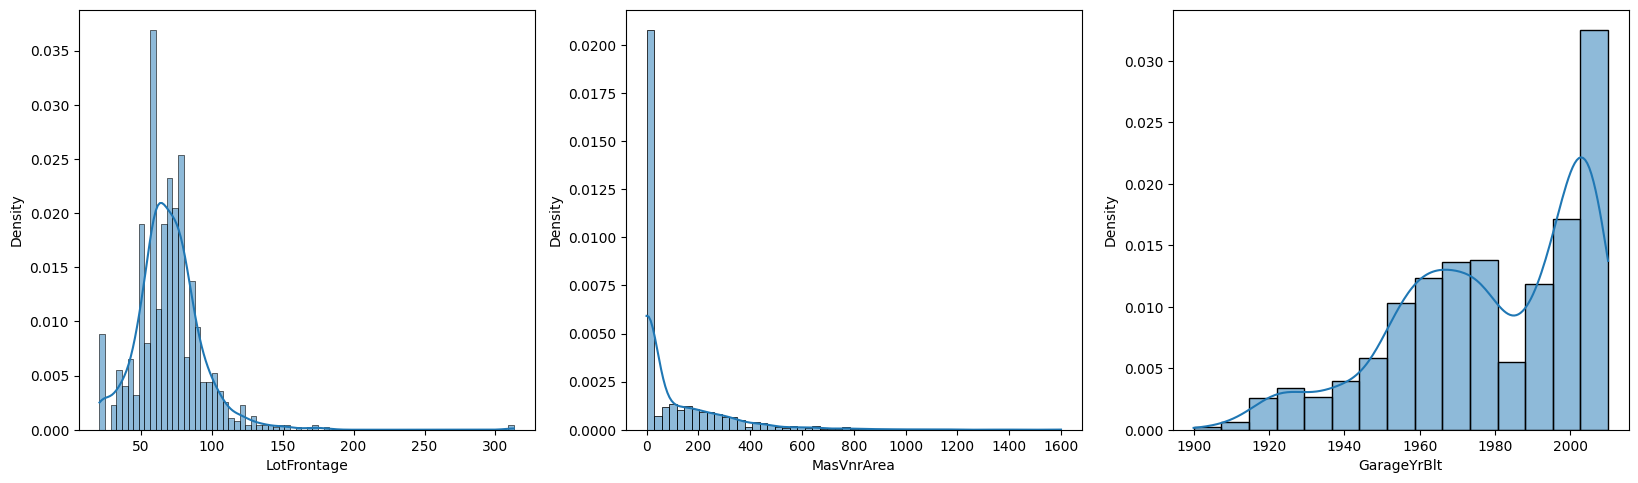

In [355]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.histplot(data=housing_df, x = 'LotFrontage', stat='density', kde = True)

plt.subplot(2,3,2)
sns.histplot(data=housing_df, x = 'MasVnrArea', stat='density', kde = True)

plt.subplot(2,3,3)
sns.histplot(data=housing_df, x = 'GarageYrBlt', stat='density', kde = True)

In [356]:
# As per the data dictionary "LotFrontage" is Linear feet of street connected to property.
# Since it is a numeric with a fair distribution, it can be imputed with similar 'Neighborhood' values
housing_df['LotFrontage'] = housing_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
housing_df["GarageYrBlt"].fillna(housing_df["GarageYrBlt"].median(), inplace=True)
housing_df["MasVnrArea"].fillna(housing_df["MasVnrArea"].median(), inplace=True)

<Axes: xlabel='GarageYrBlt', ylabel='Density'>

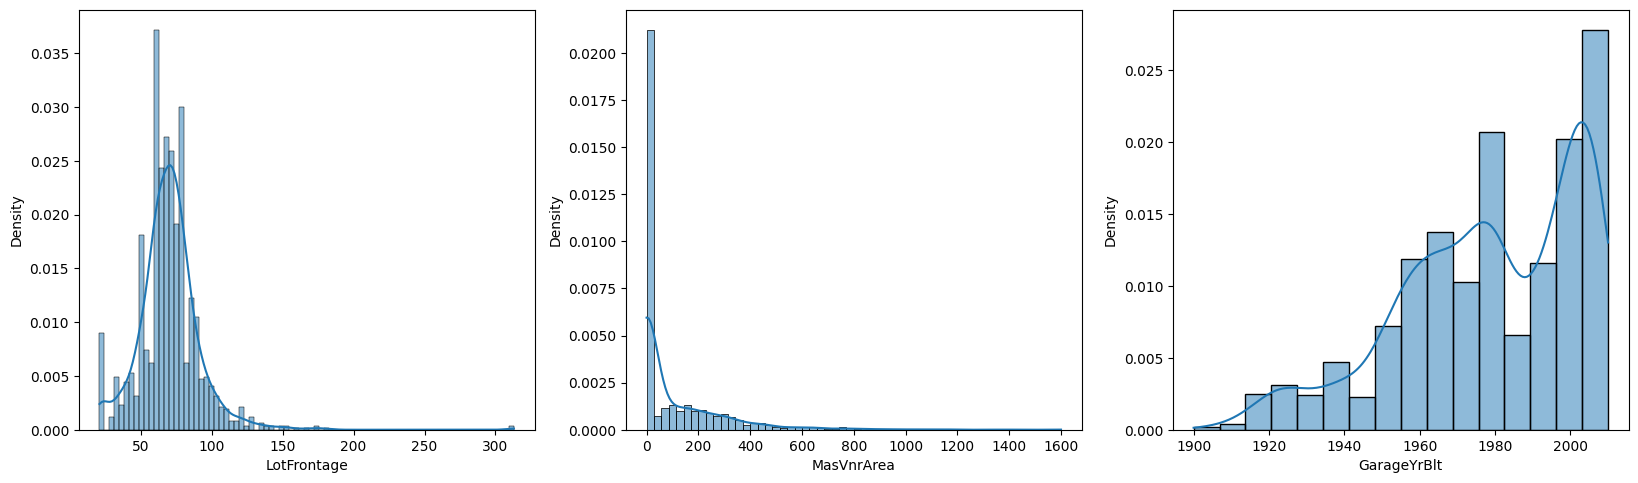

In [357]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.histplot(data=housing_df, x = 'LotFrontage', stat='density', kde = True)

plt.subplot(2,3,2)
sns.histplot(data=housing_df, x = 'MasVnrArea', stat='density', kde = True)

plt.subplot(2,3,3)
sns.histplot(data=housing_df, x = 'GarageYrBlt', stat='density', kde = True)

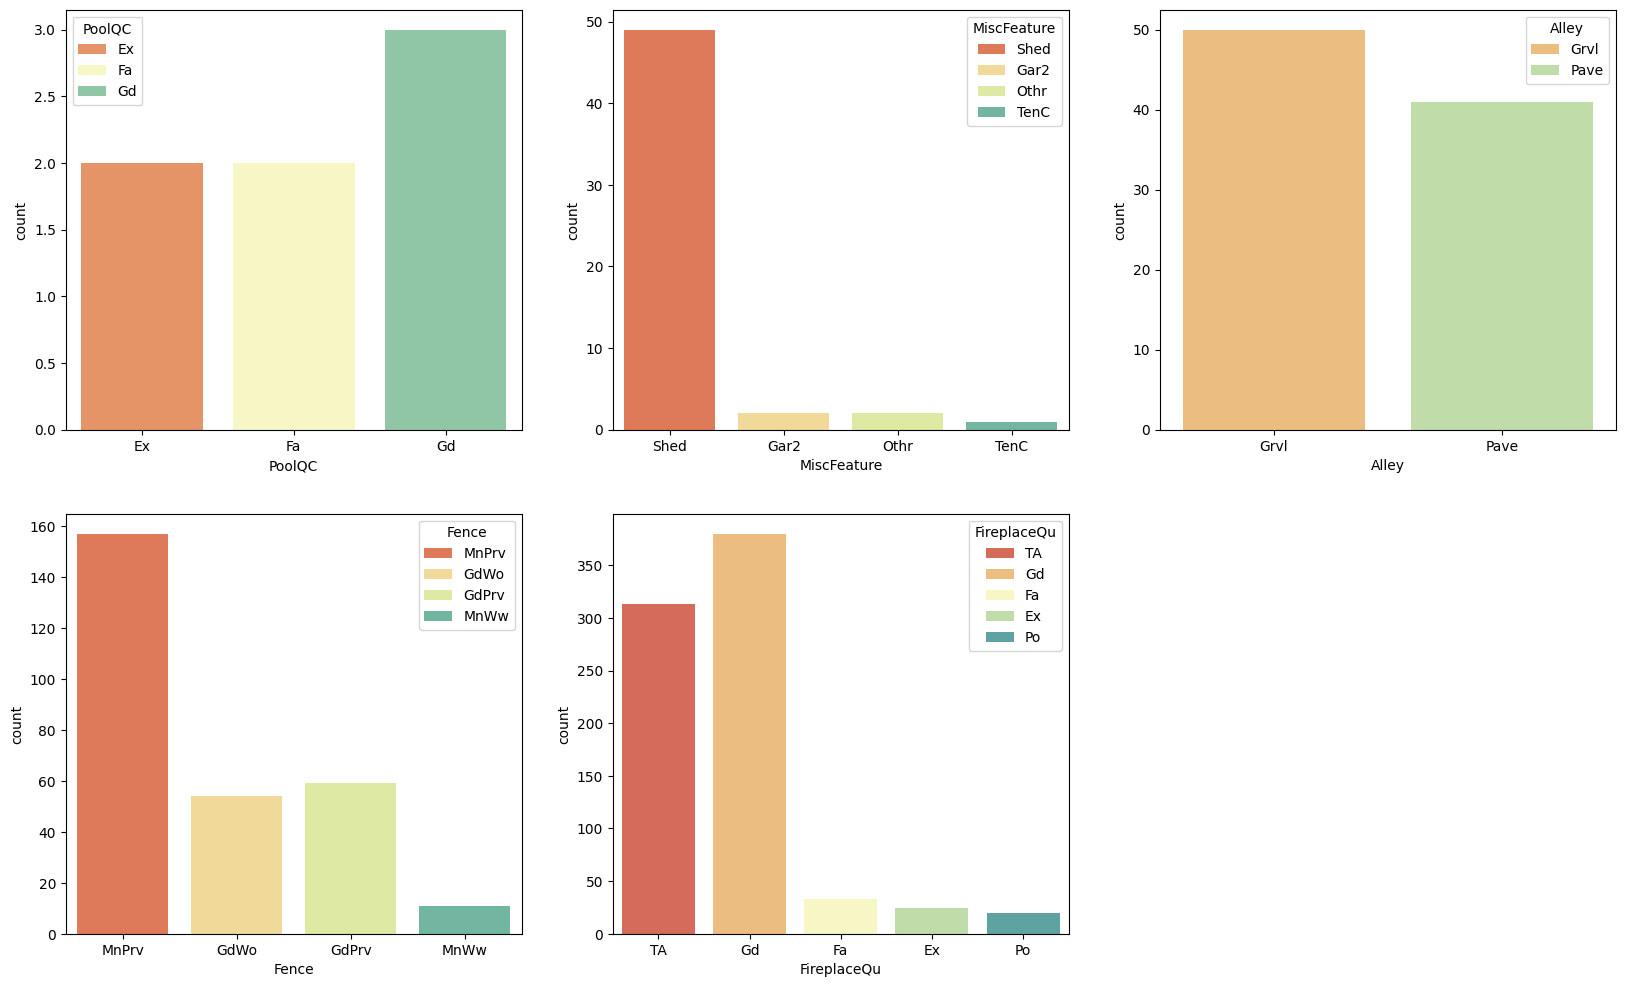

In [358]:
#Visualising the variables wih missing values
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'PoolQC', data = housing_df, hue = 'PoolQC', palette = 'Spectral')

plt.subplot(2,3,2)
sns.countplot(x = 'MiscFeature', data = housing_df, hue = 'MiscFeature', palette = 'Spectral')

plt.subplot(2,3,3)
sns.countplot(x = 'Alley', data = housing_df, hue = 'Alley', palette = 'Spectral')

plt.subplot(2,3,4)
sns.countplot(x = 'Fence', data = housing_df, hue = 'Fence', palette = 'Spectral')

plt.subplot(2,3,5)
sns.countplot(x = 'FireplaceQu', data = housing_df, hue = 'FireplaceQu', palette = 'Spectral')

#plt.subplot(2,3,6)
#sns.countplot(x = 'LotFrontage', data = housing_df, hue = 'LotFrontage', palette = 'Spectral')

plt.show()

In [359]:
# Cases where garage information is null replacing with equivalent of No Garage
housing_df['PoolQC'] = housing_df['PoolQC'].replace(np.nan, 'NA')
housing_df['MiscFeature'] = housing_df['MiscFeature'].replace(np.nan, 'NA')
housing_df['Alley'] = housing_df['Alley'].replace(np.nan, 'NA')
housing_df['Fence'] = housing_df['Fence'].replace(np.nan, 'NA')
housing_df['FireplaceQu'] = housing_df['FireplaceQu'].replace(np.nan, 'NA')
housing_df['LotFrontage']= housing_df.LotFrontage.fillna(housing_df.LotFrontage.median()) #Can see a presence of outlier so imputing the missing values through median
#housing_df['LotFrontage'] = housing_df['LotFrontage'].replace(np.nan, 'None')

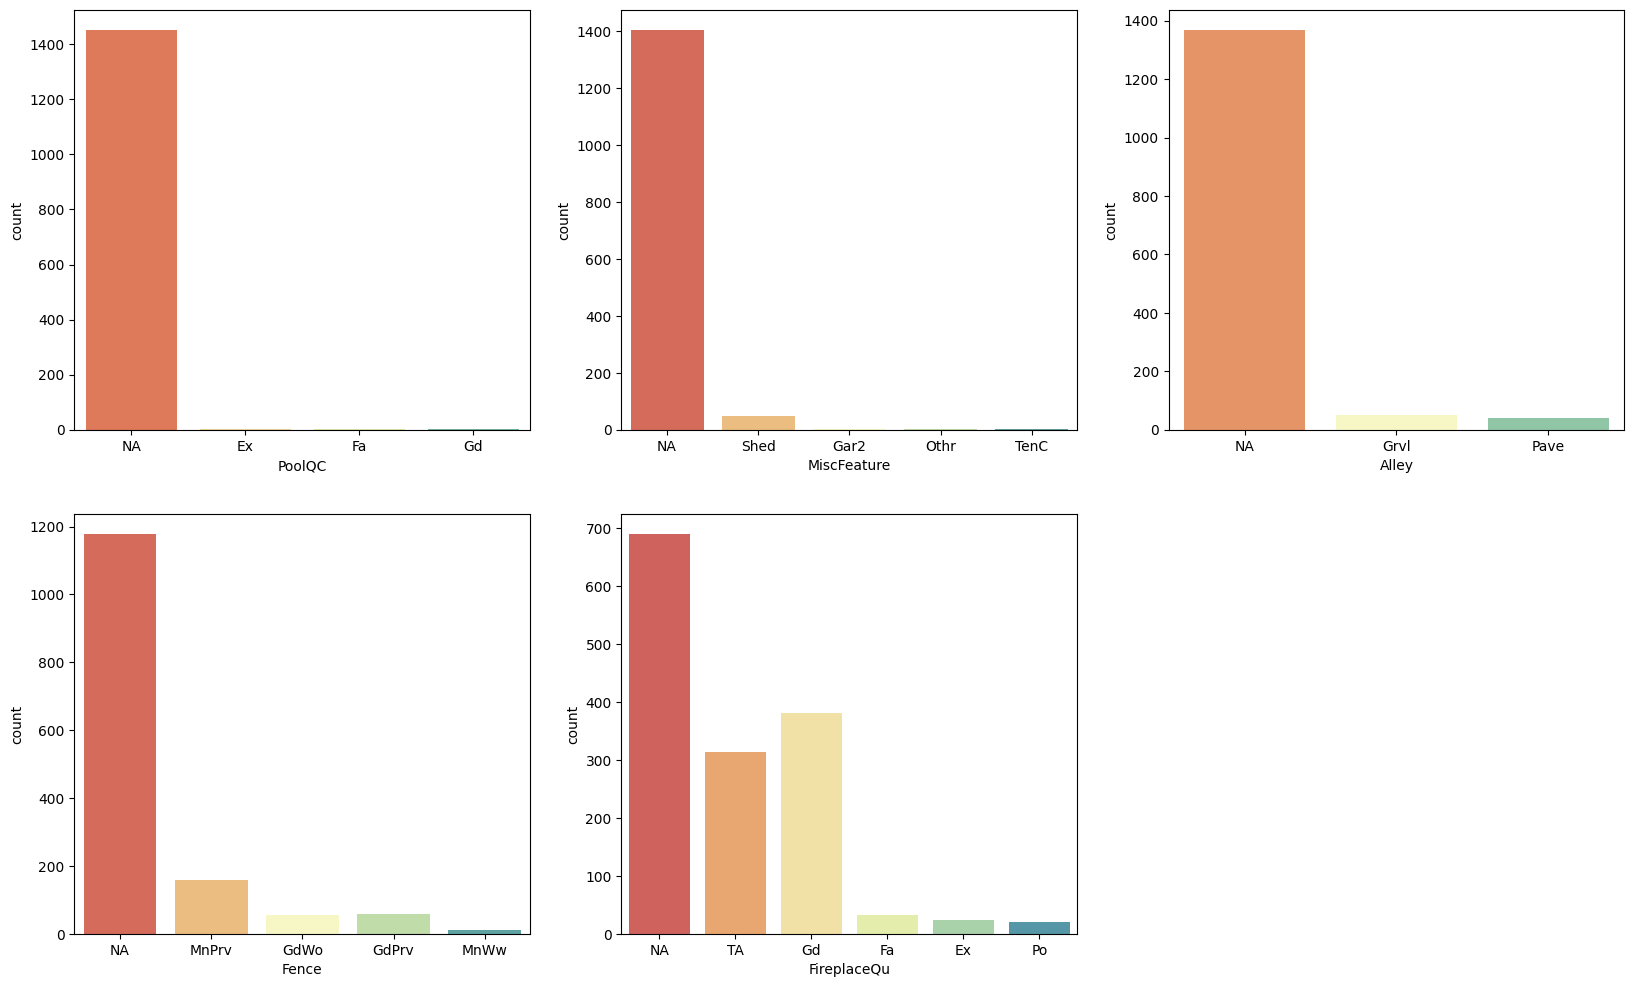

In [360]:
#Visualising the variables wih missing values
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'PoolQC', data = housing_df, hue = 'PoolQC', palette = 'Spectral')

plt.subplot(2,3,2)
sns.countplot(x = 'MiscFeature', data = housing_df, hue = 'MiscFeature', palette = 'Spectral')

plt.subplot(2,3,3)
sns.countplot(x = 'Alley', data = housing_df, hue = 'Alley', palette = 'Spectral')

plt.subplot(2,3,4)
sns.countplot(x = 'Fence', data = housing_df, hue = 'Fence', palette = 'Spectral')

plt.subplot(2,3,5)
sns.countplot(x = 'FireplaceQu', data = housing_df, hue = 'FireplaceQu', palette = 'Spectral')

#plt.subplot(2,3,6)
#sns.countplot(x = 'LotFrontage', data = housing_df, hue = 'LotFrontage', palette = 'Spectral')

plt.show()

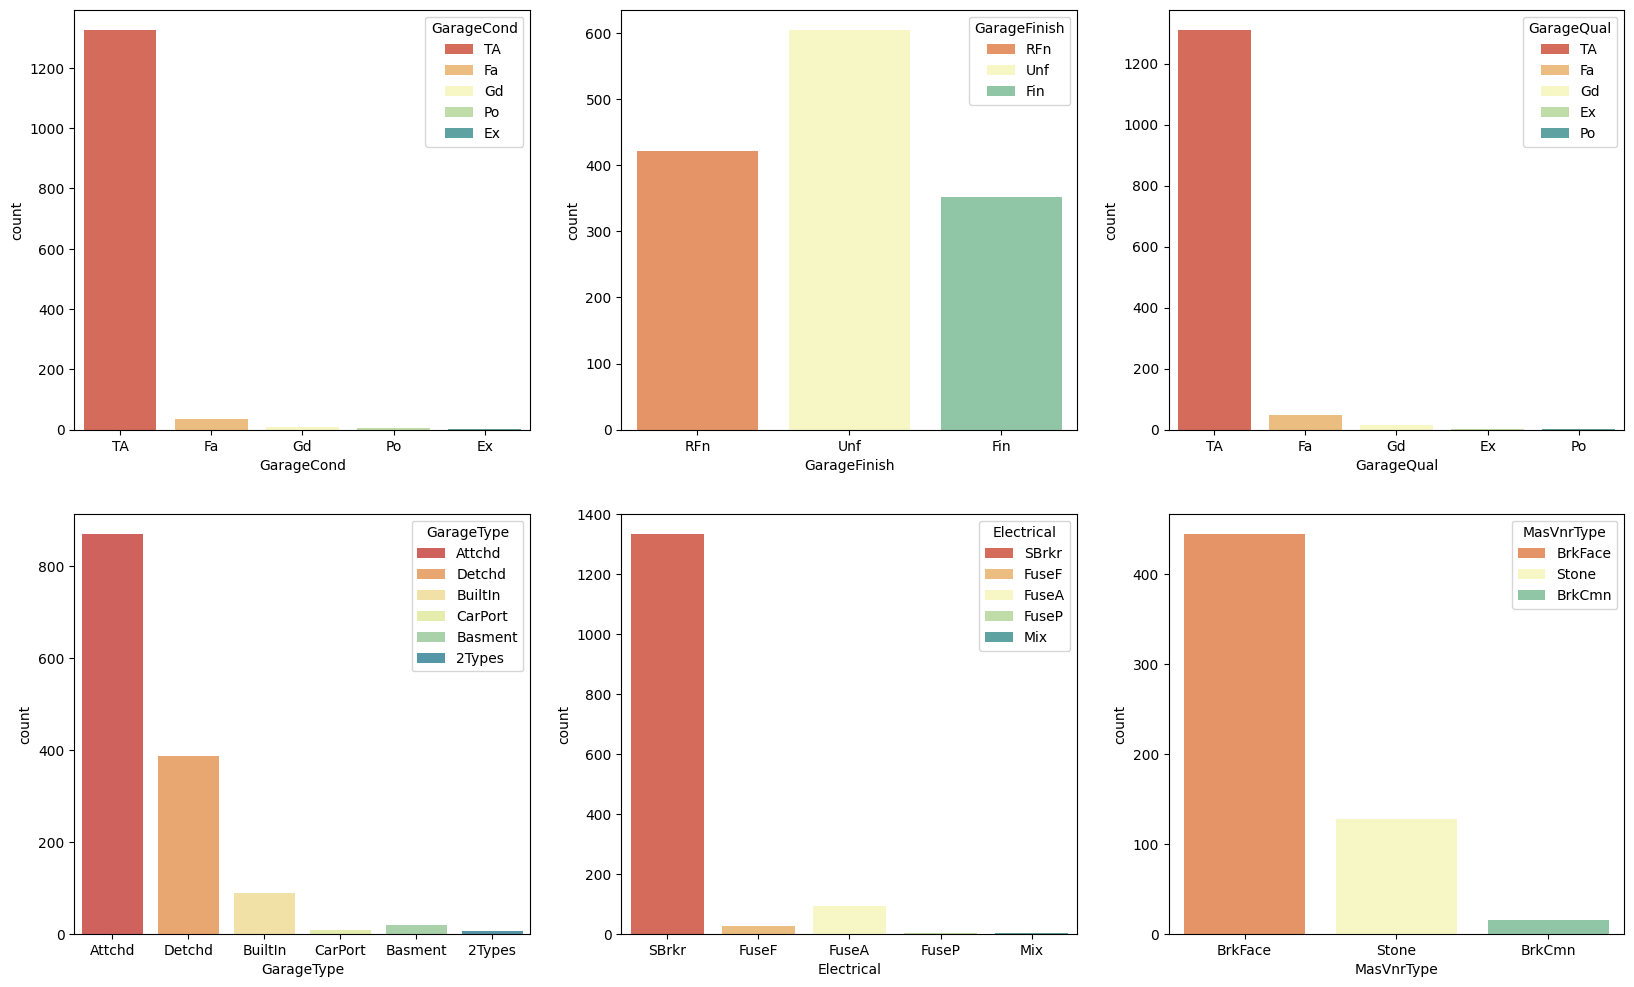

In [361]:
#Visualising the variables wih missing values
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'GarageCond', data = housing_df, hue = 'GarageCond', palette = 'Spectral')

plt.subplot(2,3,2)
sns.countplot(x = 'GarageFinish', data = housing_df, hue = 'GarageFinish', palette = 'Spectral')

plt.subplot(2,3,3)
sns.countplot(x = 'GarageQual', data = housing_df, hue = 'GarageQual', palette = 'Spectral')

plt.subplot(2,3,4)
sns.countplot(x = 'GarageType', data = housing_df, hue = 'GarageType', palette = 'Spectral')

plt.subplot(2,3,5)
sns.countplot(x = 'Electrical', data = housing_df, hue = 'Electrical', palette = 'Spectral')

plt.subplot(2,3,6)
sns.countplot(x = 'MasVnrType', data = housing_df, hue = 'MasVnrType', palette = 'Spectral')

plt.show()

In [362]:
# Cases where garage information is null replacing with equivalent of No Garage
housing_df['GarageCond'] = housing_df['GarageCond'].replace(np.nan, 'NA')
housing_df['GarageFinish'] = housing_df['GarageFinish'].replace(np.nan, 'NA')
housing_df['GarageQual'] = housing_df['GarageQual'].replace(np.nan, 'NA')
housing_df['GarageType'] = housing_df['GarageType'].replace(np.nan, 'NA')
housing_df['Electrical'] = housing_df['Electrical'].replace(np.nan, 'SBrkr')
housing_df['MasVnrType'] = housing_df['MasVnrType'].replace(np.nan, 'None')

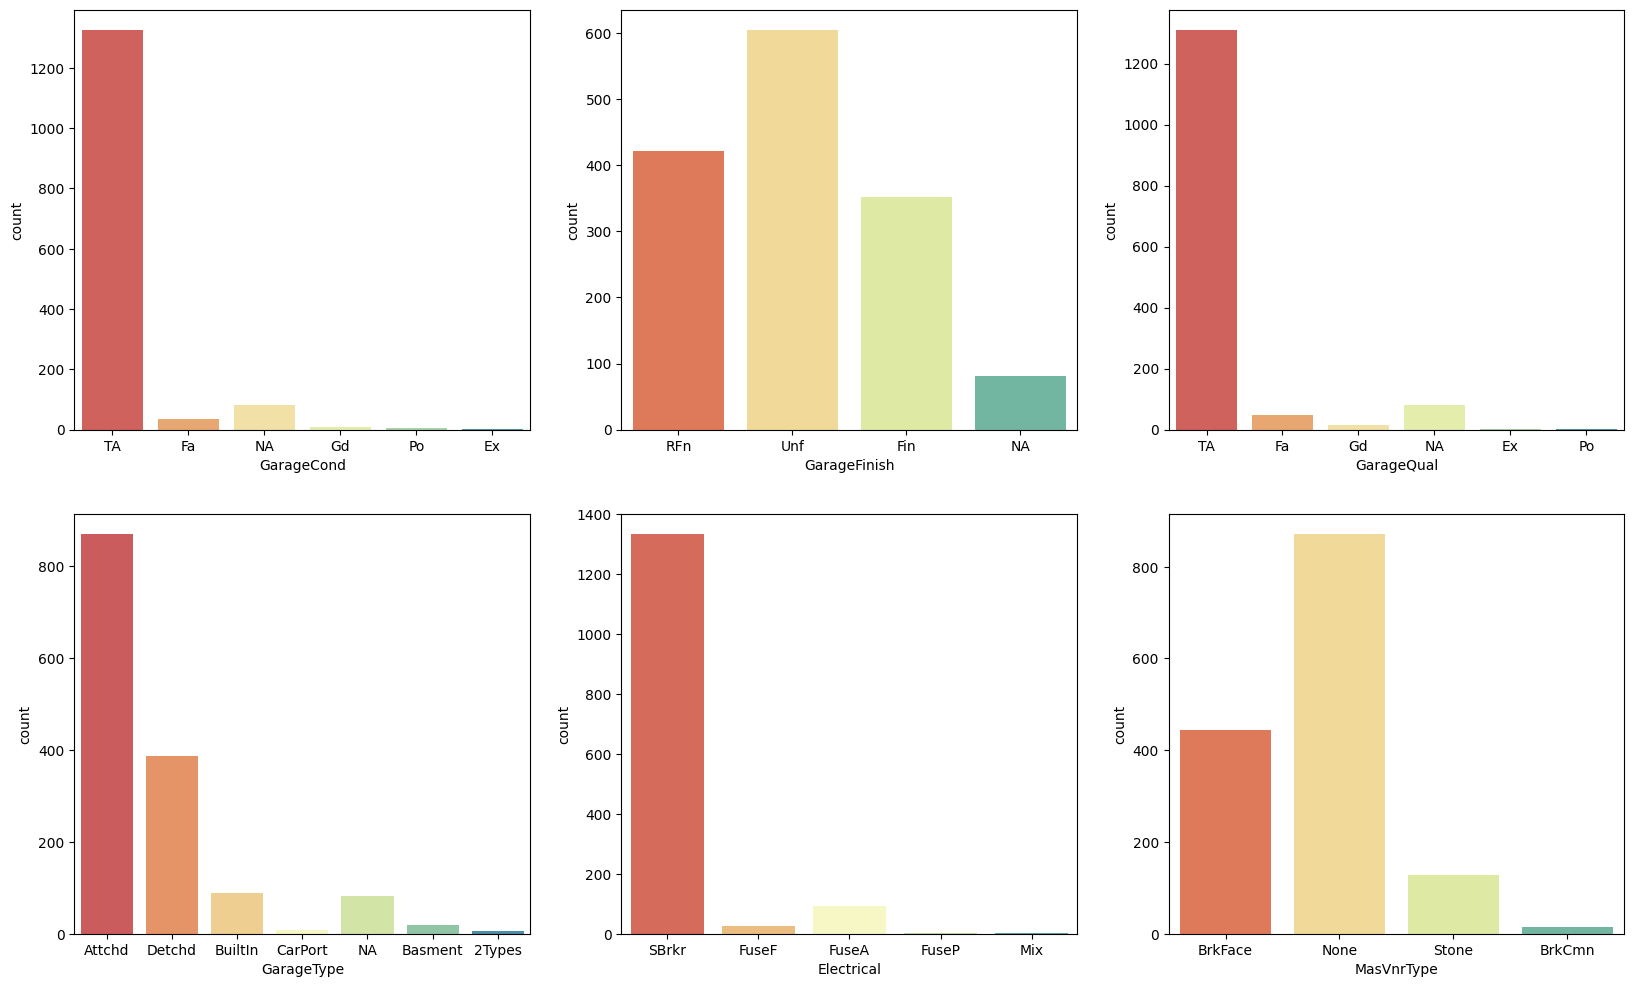

In [363]:
#Visualising the variables wih missing values
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'GarageCond', data = housing_df, hue = 'GarageCond', palette = 'Spectral')

plt.subplot(2,3,2)
sns.countplot(x = 'GarageFinish', data = housing_df, hue = 'GarageFinish', palette = 'Spectral')

plt.subplot(2,3,3)
sns.countplot(x = 'GarageQual', data = housing_df, hue = 'GarageQual', palette = 'Spectral')

plt.subplot(2,3,4)
sns.countplot(x = 'GarageType', data = housing_df, hue = 'GarageType', palette = 'Spectral')

plt.subplot(2,3,5)
sns.countplot(x = 'Electrical', data = housing_df, hue = 'Electrical', palette = 'Spectral')

plt.subplot(2,3,6)
sns.countplot(x = 'MasVnrType', data = housing_df, hue = 'MasVnrType', palette = 'Spectral')

plt.show()

In [364]:
#changing num to categorical so as to form these as dummy variables
housing_df['MSSubClass'] = housing_df['MSSubClass'].replace(
    {
        20:'1-STORY 1946 & NEWER ALL STYLES',
        30:'1-STORY 1945 & OLDER',
        40:'1-STORY W/FINISHED ATTIC ALL AGES',
        45:'1-1/2 STORY - UNFINISHED ALL AGES',
        50:'1-1/2 STORY FINISHED ALL AGES',
        60:'2-STORY 1946 & NEWER',
        70:'2-STORY 1945 & OLDER',
        75:'2-1/2 STORY ALL AGES',
        80:'SPLIT OR MULTI-LEVEL',
        85:'SPLIT FOYER',
        90:'DUPLEX - ALL STYLES AND AGES',
       120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
       150:'1-1/2 STORY PUD - ALL AGES',
       160:'2-STORY PUD - 1946 & NEWER',
       180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
       190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'
  }
)

housing_df['OverallQual'] = housing_df['OverallQual'].replace(
    {
      10:'Very Excellent',
      9:'Excellent',
      8:'Very Good',
      7:'Good',
      6:'Above Average',
      5:'Average',
      4:'Below Average',
      3:'Fair',
      2:'Poor',
      1:'Very Poor'
    }
  )

housing_df['OverallCond'] = housing_df['OverallCond'].replace({ 10:'Very Excellent',
       9:'Excellent',
       8:'Very Good',
       7:'Good',
       6:'Above Average',
       5:'Average',
       4:'Below Average',
       3:'Fair',
       2:'Poor',
       1:'Very Poor'})

In [365]:
housing_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,2-STORY 1946 & NEWER,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,2-STORY 1946 & NEWER,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,2-STORY 1945 & OLDER,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,2-STORY 1946 & NEWER,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


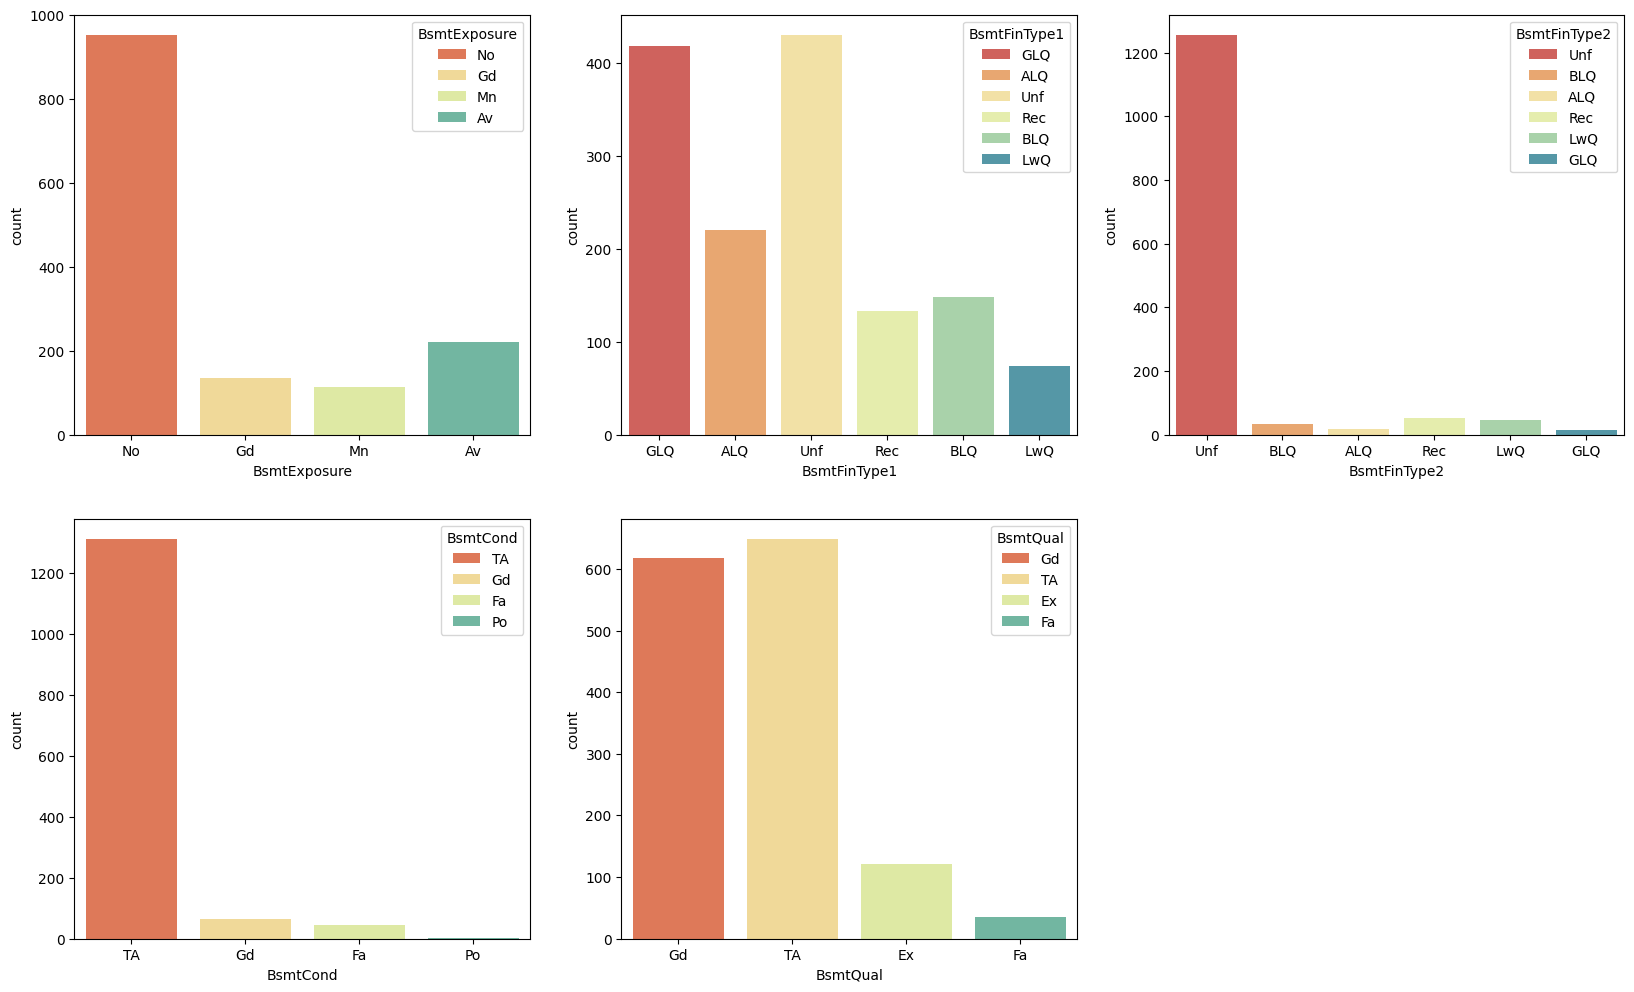

In [366]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'BsmtExposure', data = housing_df, hue = 'BsmtExposure', palette = 'Spectral')

plt.subplot(2,3,2)
sns.countplot(x = 'BsmtFinType1', data = housing_df, hue = 'BsmtFinType1', palette = 'Spectral')

plt.subplot(2,3,3)
sns.countplot(x = 'BsmtFinType2',  data = housing_df, hue = 'BsmtFinType2', palette = 'Spectral')

plt.subplot(2,3,4)
sns.countplot(x = 'BsmtCond', data = housing_df, hue = 'BsmtCond', palette = 'Spectral')

plt.subplot(2,3,5)
sns.countplot(x = 'BsmtQual',  data = housing_df, hue = 'BsmtQual', palette = 'Spectral')

plt.show()

In [367]:
# Cases when the house doesn't have the basement so replacing null with No Basement
housing_df['BsmtExposure'] = housing_df['BsmtExposure'].replace(np.nan, 'NA')
housing_df['BsmtFinType1'] = housing_df['BsmtFinType1'].replace(np.nan, 'NA')
housing_df['BsmtFinType2'] = housing_df['BsmtFinType2'].replace(np.nan, 'NA')
housing_df['BsmtCond'] = housing_df['BsmtCond'].replace(np.nan, 'NA')
housing_df['BsmtQual'] = housing_df['BsmtQual'].replace(np.nan, 'NA')

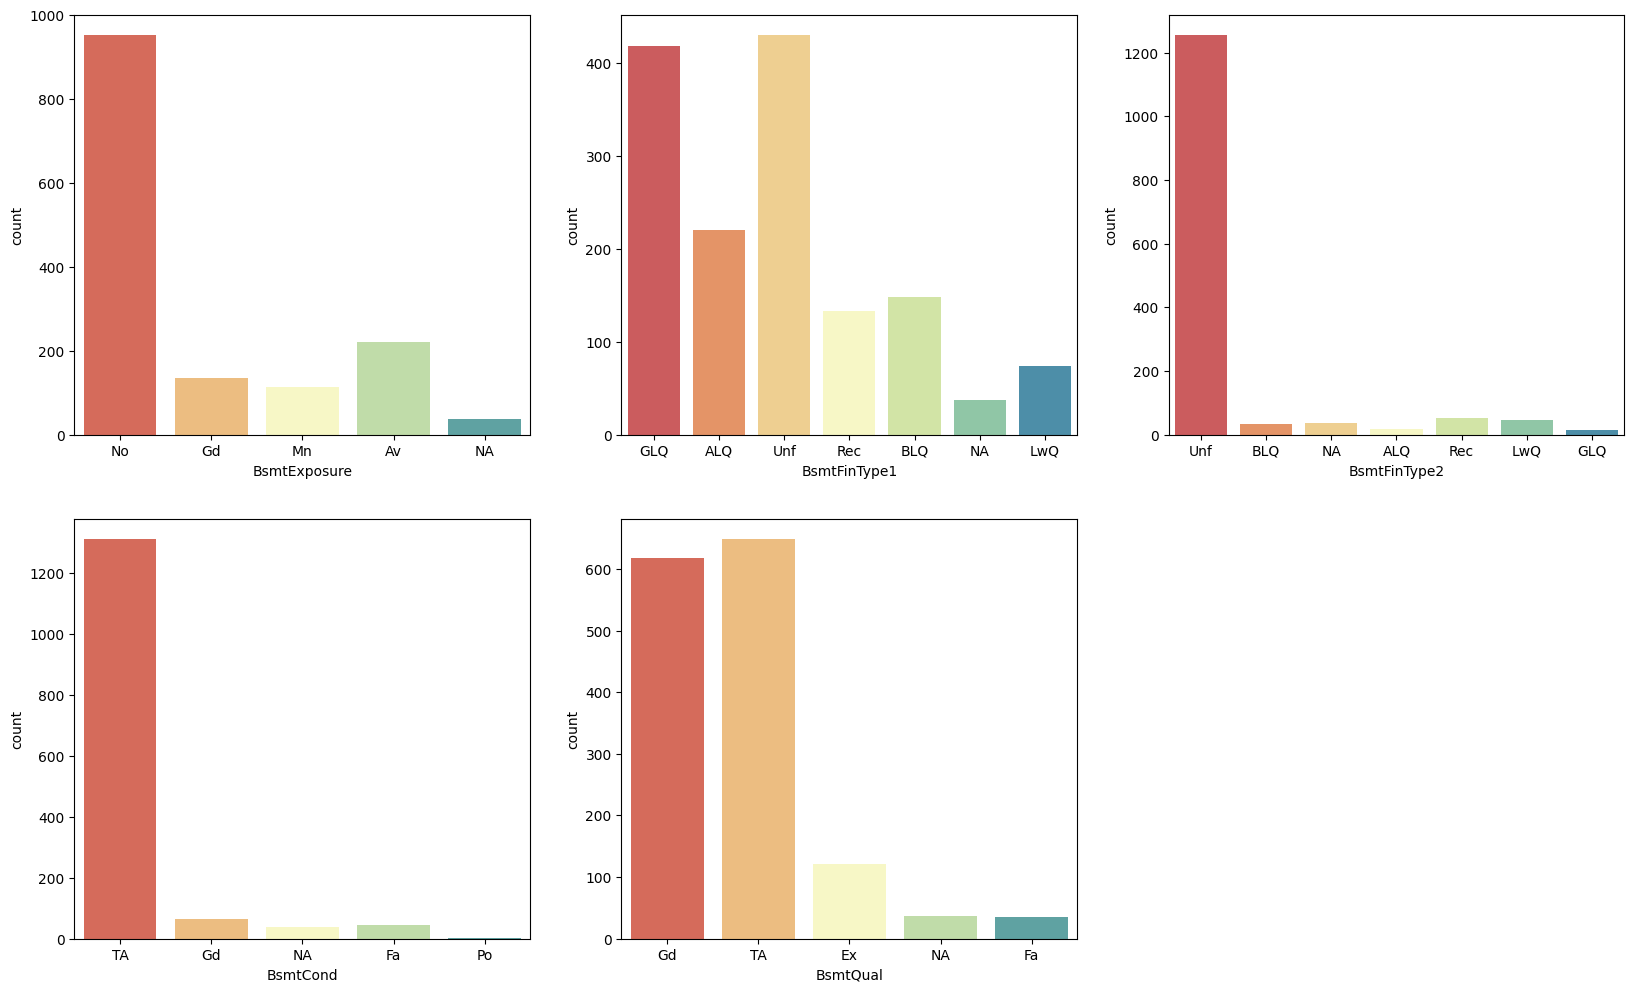

In [368]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'BsmtExposure', data = housing_df, hue = 'BsmtExposure', palette = 'Spectral')

plt.subplot(2,3,2)
sns.countplot(x = 'BsmtFinType1', data = housing_df, hue = 'BsmtFinType1', palette = 'Spectral')

plt.subplot(2,3,3)
sns.countplot(x = 'BsmtFinType2',  data = housing_df, hue = 'BsmtFinType2', palette = 'Spectral')

plt.subplot(2,3,4)
sns.countplot(x = 'BsmtCond', data = housing_df, hue = 'BsmtCond', palette = 'Spectral')

plt.subplot(2,3,5)
sns.countplot(x = 'BsmtQual',  data = housing_df, hue = 'BsmtQual', palette = 'Spectral')

plt.show()

In [369]:
calculate_missing_percent(housing_df, 15)

Id              0.0
CentralAir      0.0
GarageYrBlt     0.0
GarageType      0.0
FireplaceQu     0.0
Fireplaces      0.0
Functional      0.0
TotRmsAbvGrd    0.0
KitchenQual     0.0
KitchenAbvGr    0.0
BedroomAbvGr    0.0
HalfBath        0.0
FullBath        0.0
BsmtHalfBath    0.0
BsmtFullBath    0.0
dtype: float64

##Step 4: Perform EDA

In [370]:
#Let's check the dependent variable i.e SalePrice
#descriptive statistics summary
housing_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Density'>

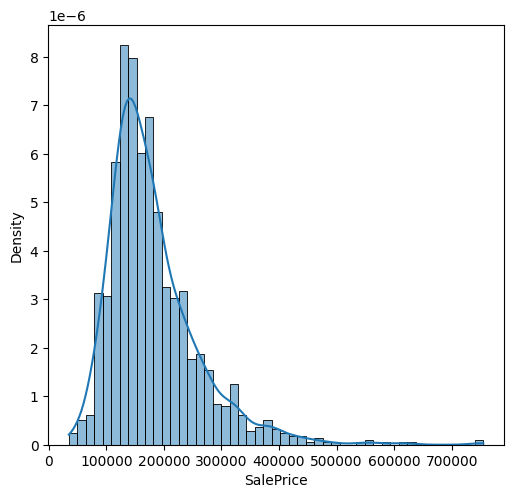

In [371]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.histplot(data=housing_df, x = 'SalePrice', stat='density', kde = True)

We can say that dependent variable SalePrice is normally distributed.

In [372]:
category_df = housing_df.select_dtypes(include=['object'])
category_df.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

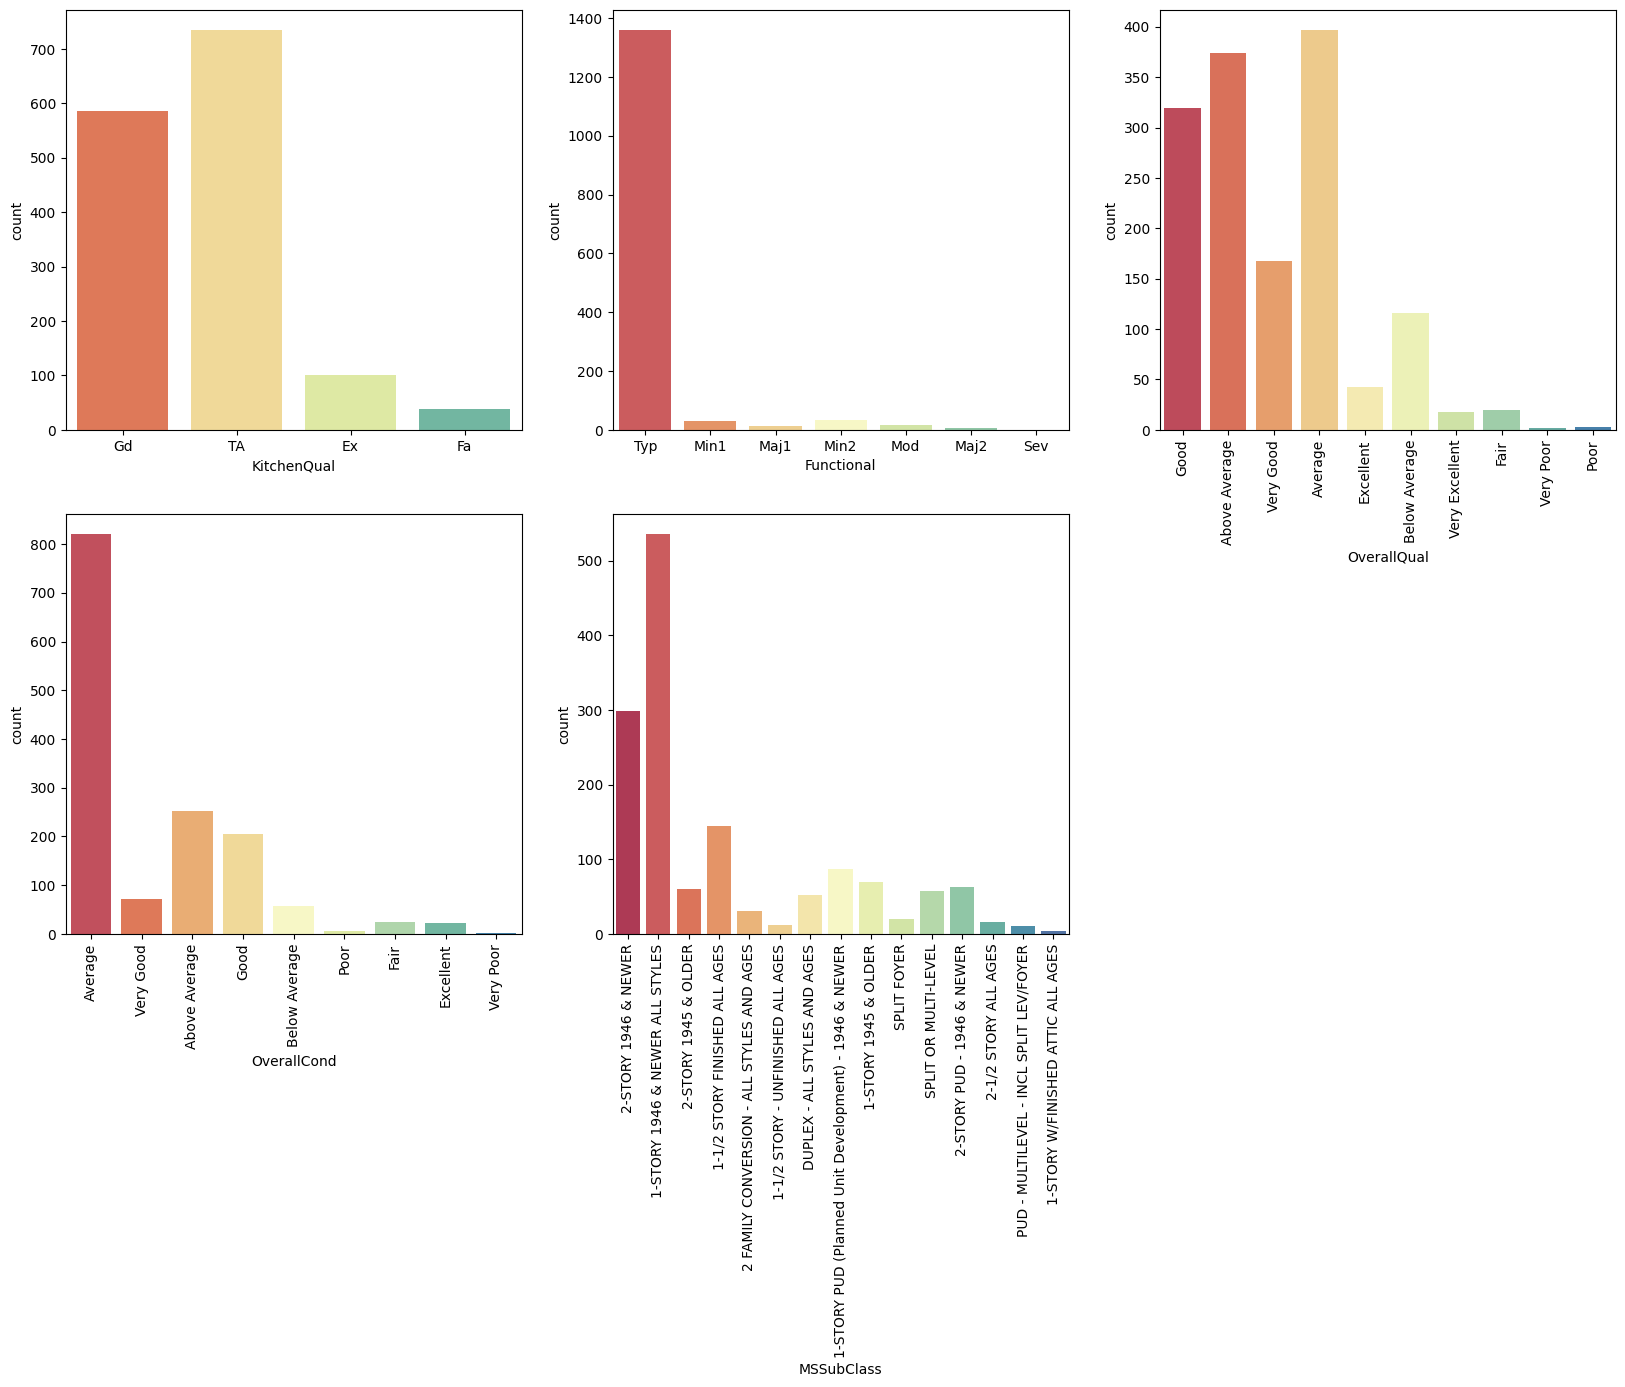

In [373]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.countplot(x = 'KitchenQual', data = housing_df, hue = 'KitchenQual', palette = 'Spectral')

plt.subplot(2,3,2)
sns.countplot(x = 'Functional', data = housing_df, hue = 'Functional', palette = 'Spectral')

plt.subplot(2,3,3)
sns.countplot(x = 'OverallQual', data = housing_df, hue = 'OverallQual', palette = 'Spectral')
plt.xticks(rotation=90)

plt.subplot(2,3,4)
sns.countplot(x = 'OverallCond', data = housing_df, hue = 'OverallCond', palette = 'Spectral')
plt.xticks(rotation=90)

plt.subplot(2,3,5)
sns.countplot(x = 'MSSubClass', data = housing_df, hue = 'MSSubClass', palette = 'Spectral')
plt.xticks(rotation=90)

plt.show()

In [374]:
# Dropping highly skewed column
housing_df.drop(['Functional'],axis=1,inplace=True)

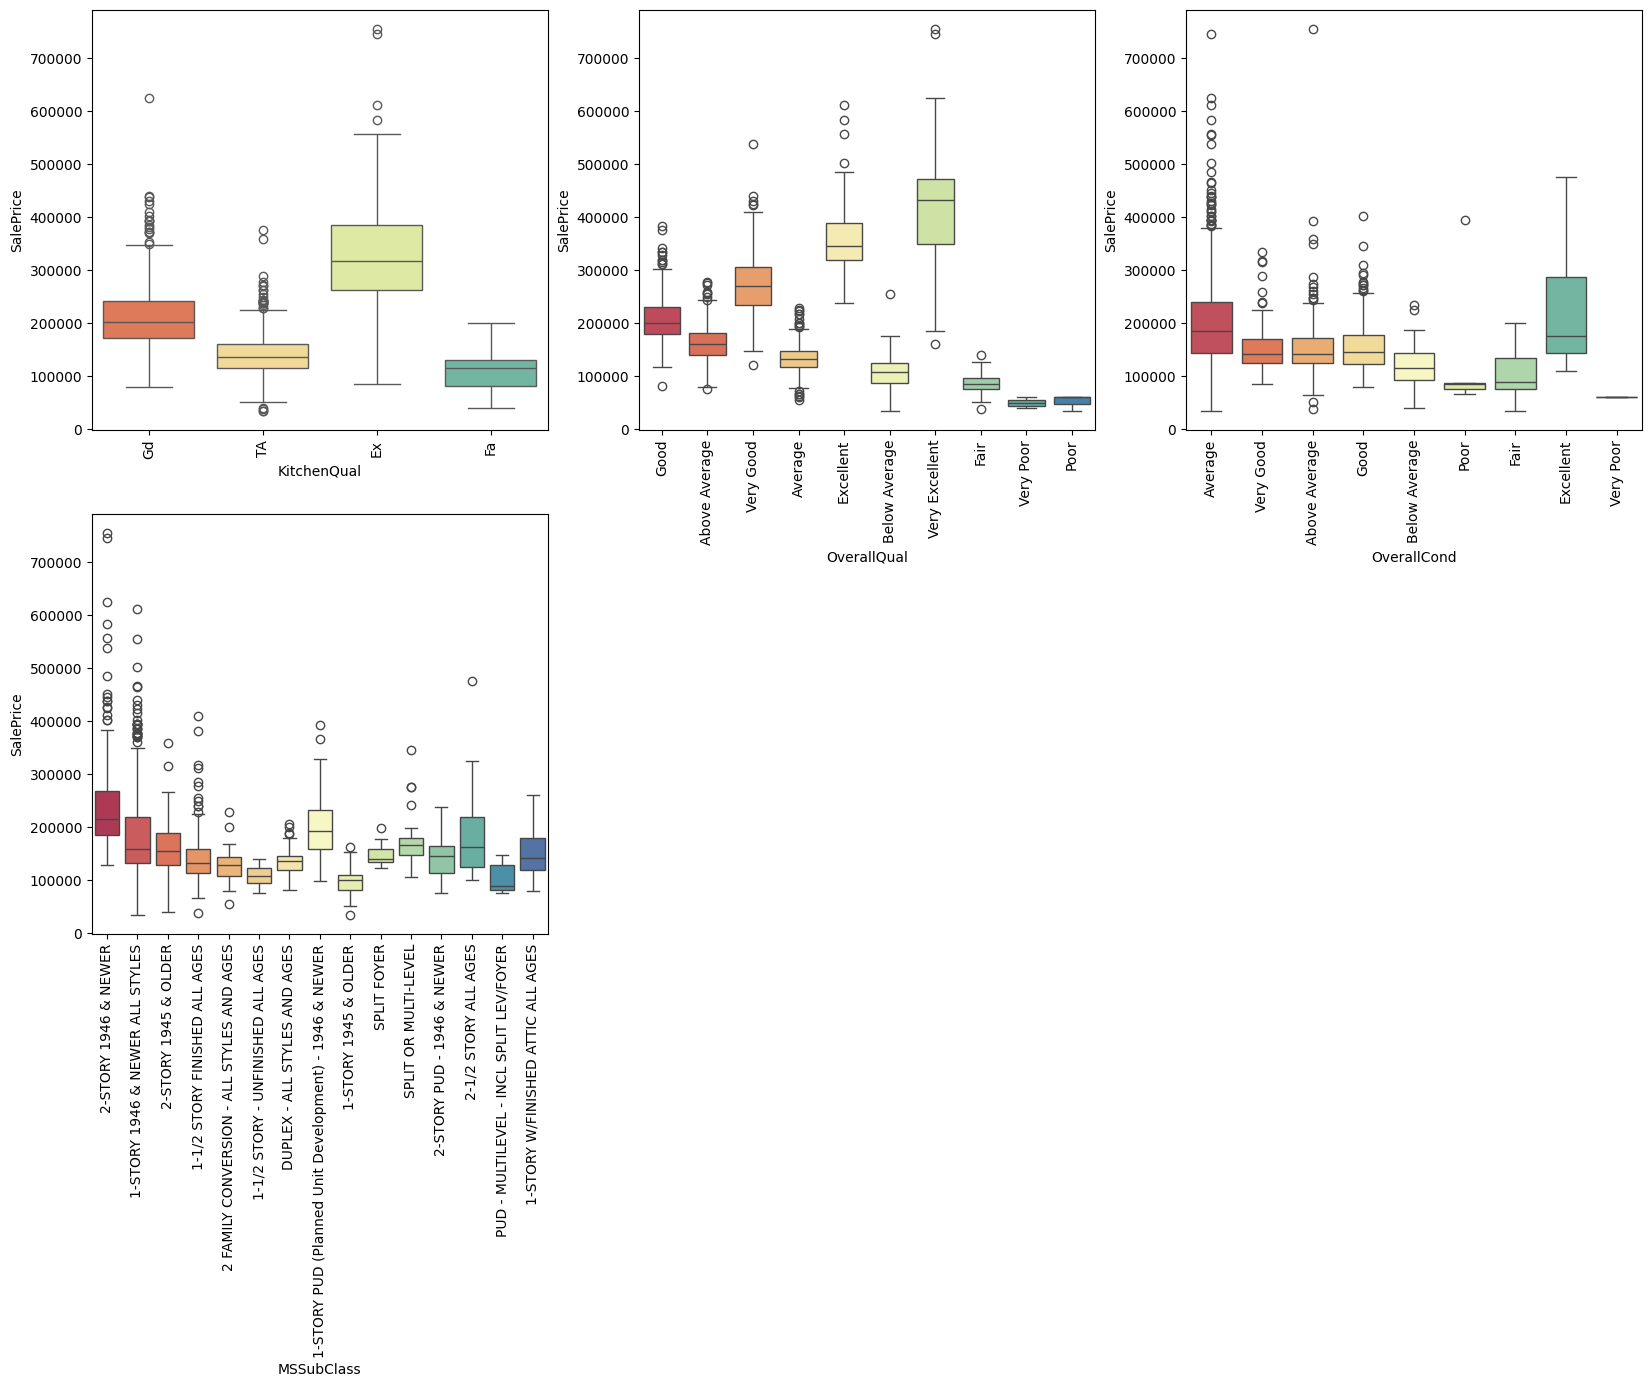

In [375]:
# Boxplot for categorical variables to see demands
vars_cat = ['KitchenQual','OverallQual','OverallCond','MSSubClass']
display_boxplot(housing_df, vars_cat, 20, 12, 2, 3,'SalePrice', True)

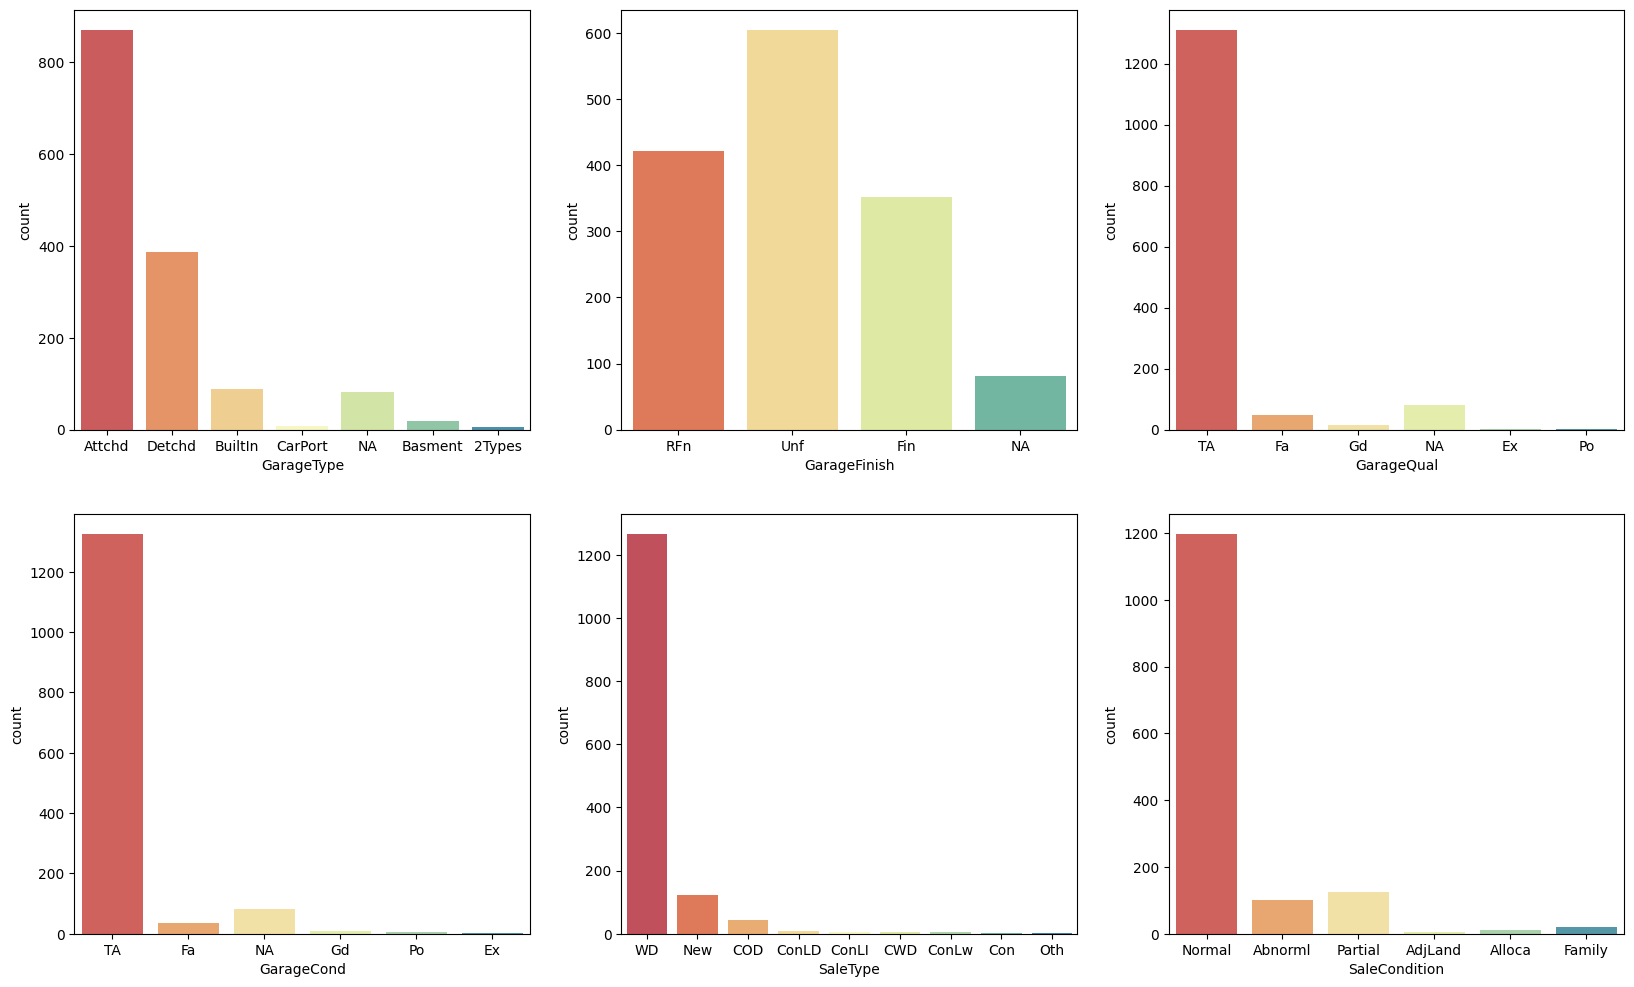

In [376]:
vars_cat = ['GarageType','GarageFinish','GarageQual','GarageCond','SaleType','SaleCondition']
display_countplot(housing_df, vars_cat, 20, 12, 2, 3)

In [377]:
#similarly checking other columns for skewness
housing_df['SaleCondition'].value_counts()

SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64

In [378]:
# Dropping highly skewed column
housing_df.drop(['GarageQual','GarageCond','SaleType'], axis=1, inplace=True)

In [379]:
housing_df['GarageType'] = housing_df['GarageType'].replace(['Basment','CarPort','2Types'],'Others')
housing_df['SaleCondition'] = housing_df['SaleCondition'].replace(['Family','Alloca','AdjLand'],'Others')

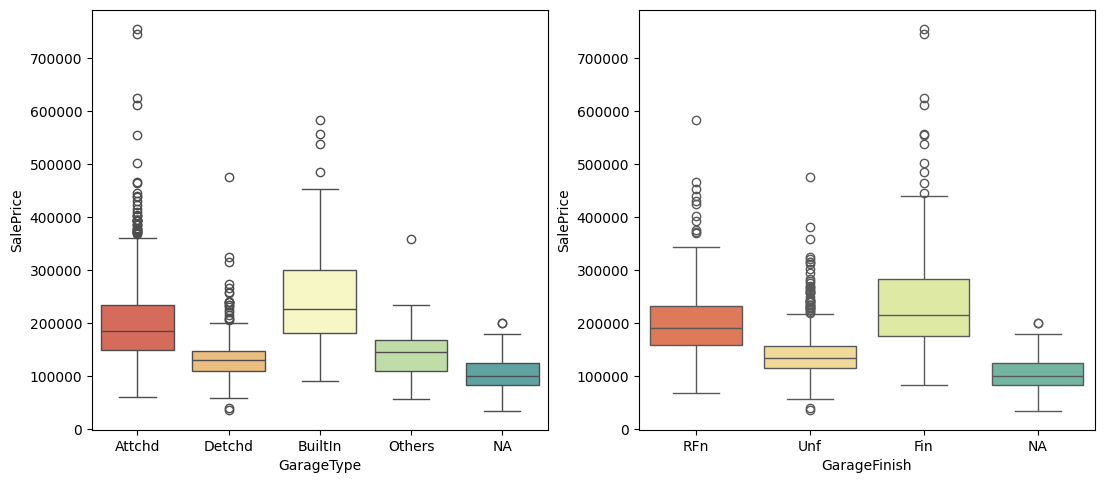

In [380]:
vars_cat = ['GarageType','GarageFinish']
display_boxplot(housing_df, vars_cat, 20, 12, 2, 3,'SalePrice')

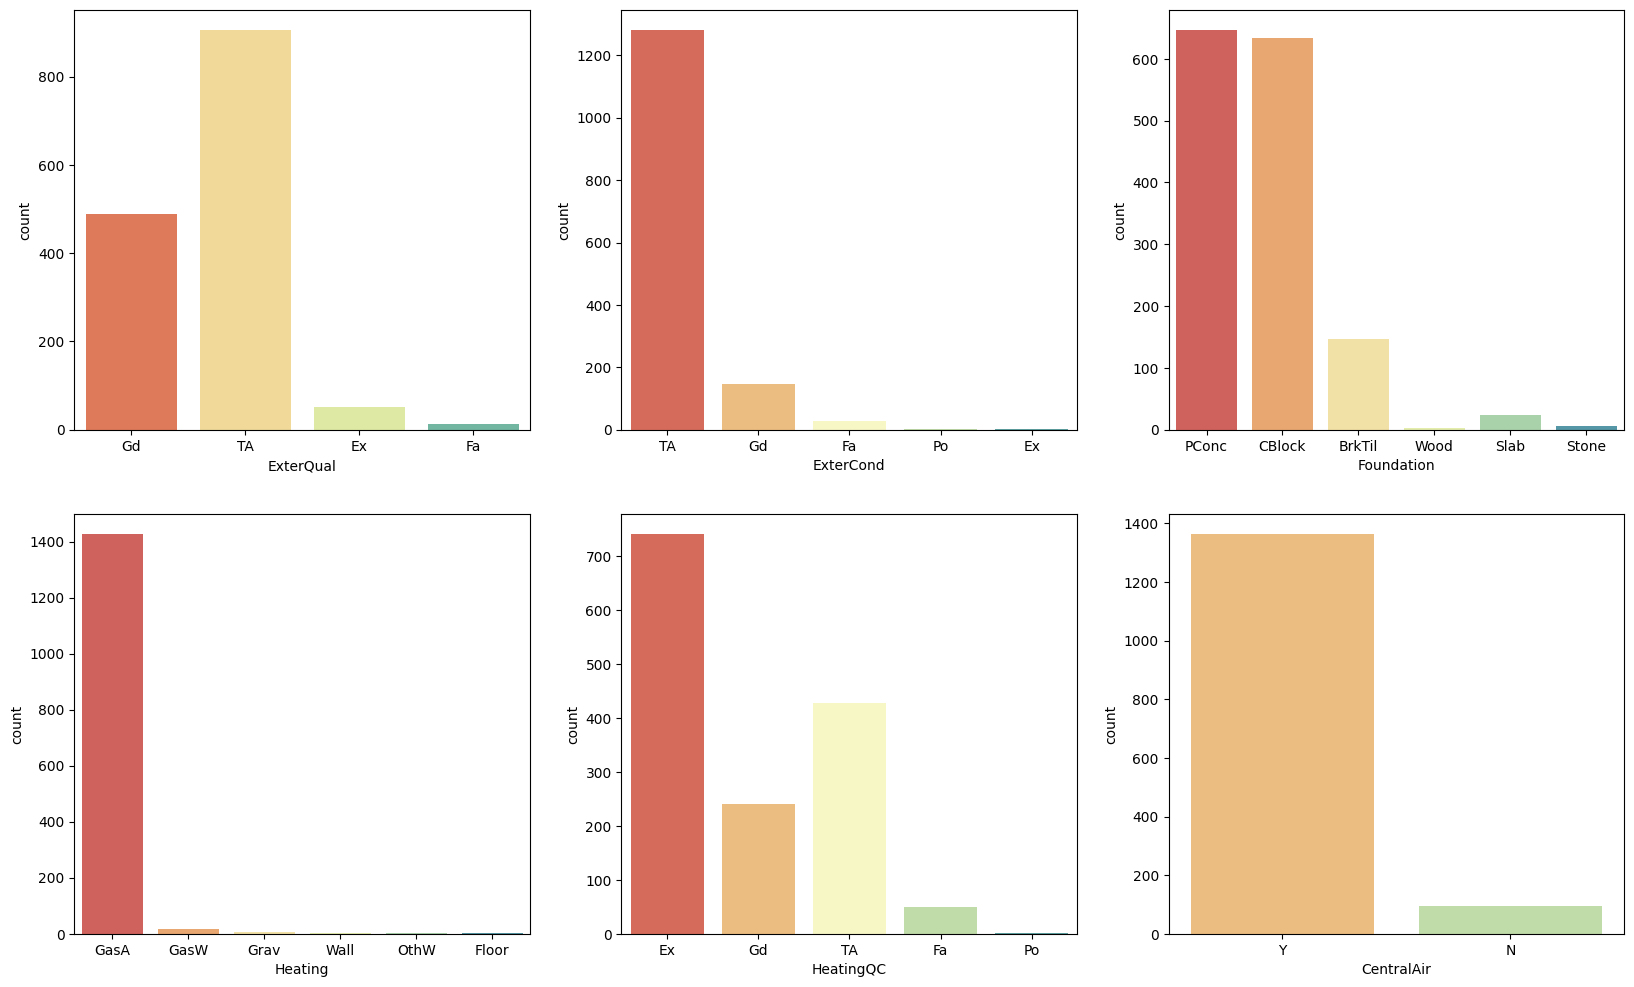

In [381]:
vars_cat = ['ExterQual','ExterCond','Foundation','Heating','HeatingQC','CentralAir']
display_countplot(housing_df, vars_cat, 20, 12, 2, 3)

*   Majority of ExterQual, ExerCond is TA
*   Poured Contrete foundation are the highest in number
*   Meanwhile variables like Heating , Central Air and Exter Cond are skewed so would be dropping these variables

In [382]:
# Dropping highly skewed column
housing_df.drop(['CentralAir','Heating','ExterCond'],axis=1,inplace=True)

In [383]:
housing_df['Foundation'] = housing_df['Foundation'].replace(['Slab','Stone','Wood'],'Others')

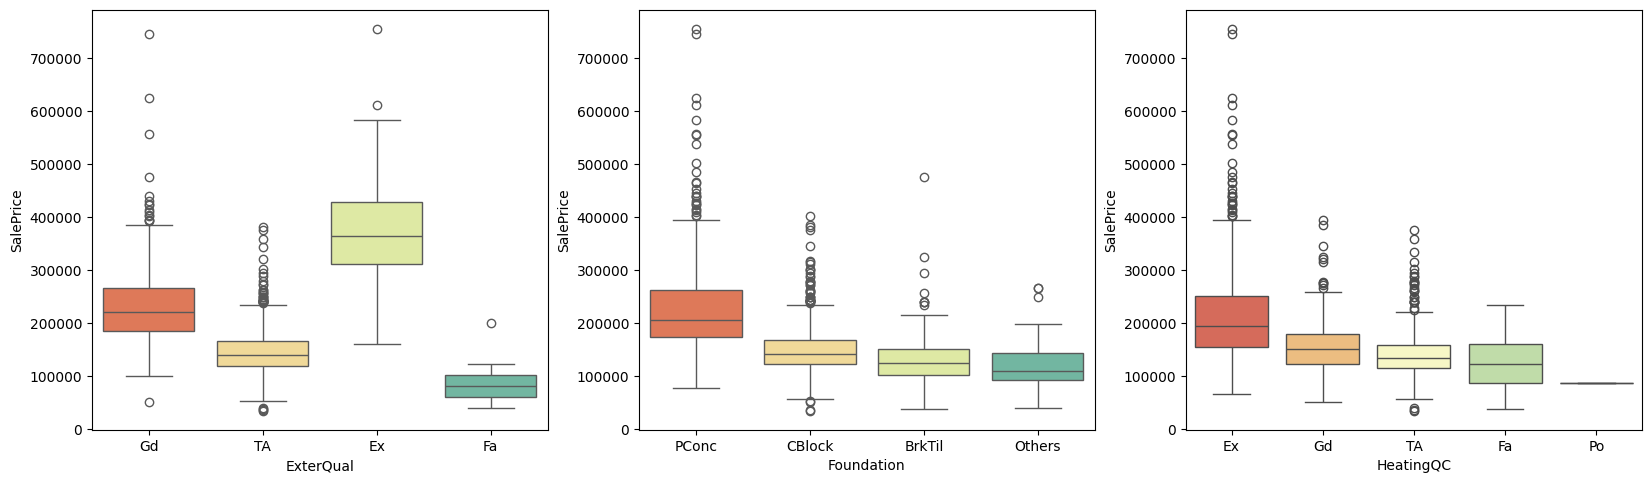

In [384]:
vars_cat = ['ExterQual','Foundation', 'HeatingQC']
display_boxplot(housing_df, vars_cat, 20, 12, 2, 3,'SalePrice')


*   Price of Excellent ExterQual and HeatingQc is highest
*   Price of Poured Contrete Foundation is highest



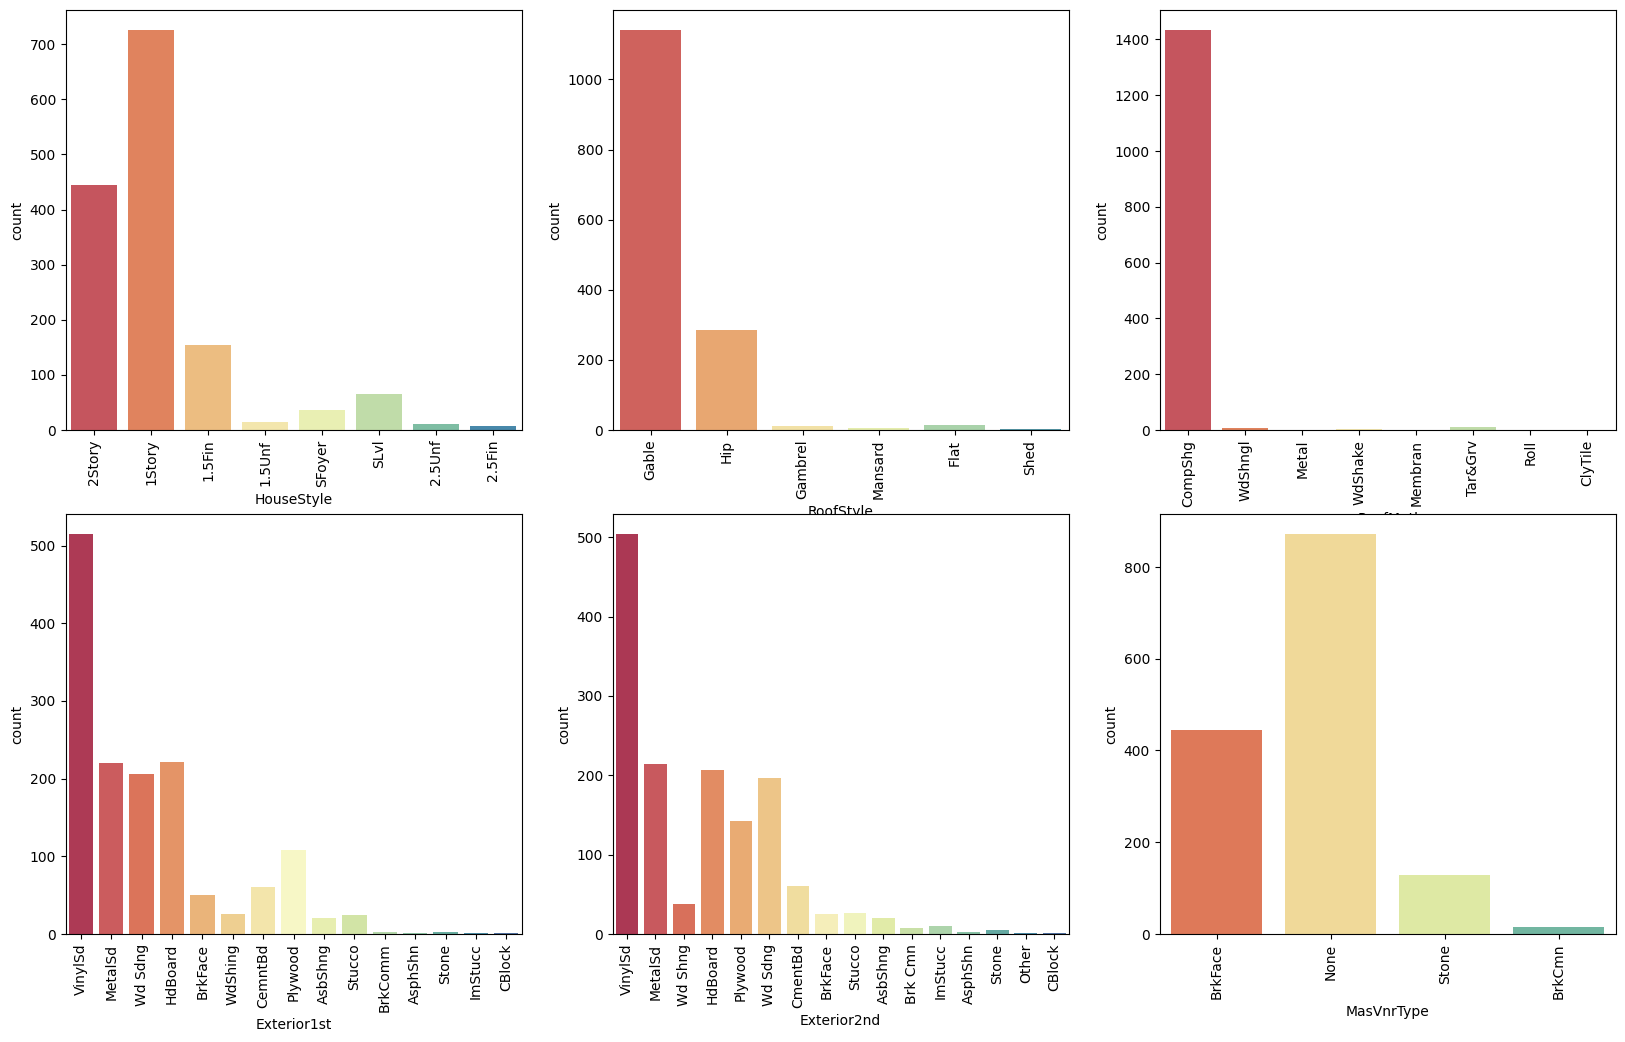

In [385]:
vars_cat = ['HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType']
display_countplot(housing_df, vars_cat, 20, 12, 2, 3, True)

In [386]:
# Dropping highly skewed column
housing_df.drop(['RoofMatl'], axis=1,inplace=True)

In [387]:
housing_df['HouseStyle'] = housing_df['HouseStyle'].replace(['SFoyer','1.5Unf','2.5Unf','2.5Fin'],'Others')
housing_df['RoofStyle'] = housing_df['RoofStyle'].replace(['Shed','Mansard','Gambrel','Flat'],'Others')
housing_df['Exterior1st'] = housing_df['Exterior1st'].replace(['AsphShn','ImStucc','CBlock','Stone','BrkComm','AsbShng','Stucco','WdShing'],'Others')
housing_df['Exterior2nd'] = housing_df['Exterior2nd'].replace(['Other','AsphShn','ImStucc','CBlock','Stone','BrkComm','AsbShng','Stucco','BrkFace'],'Others')

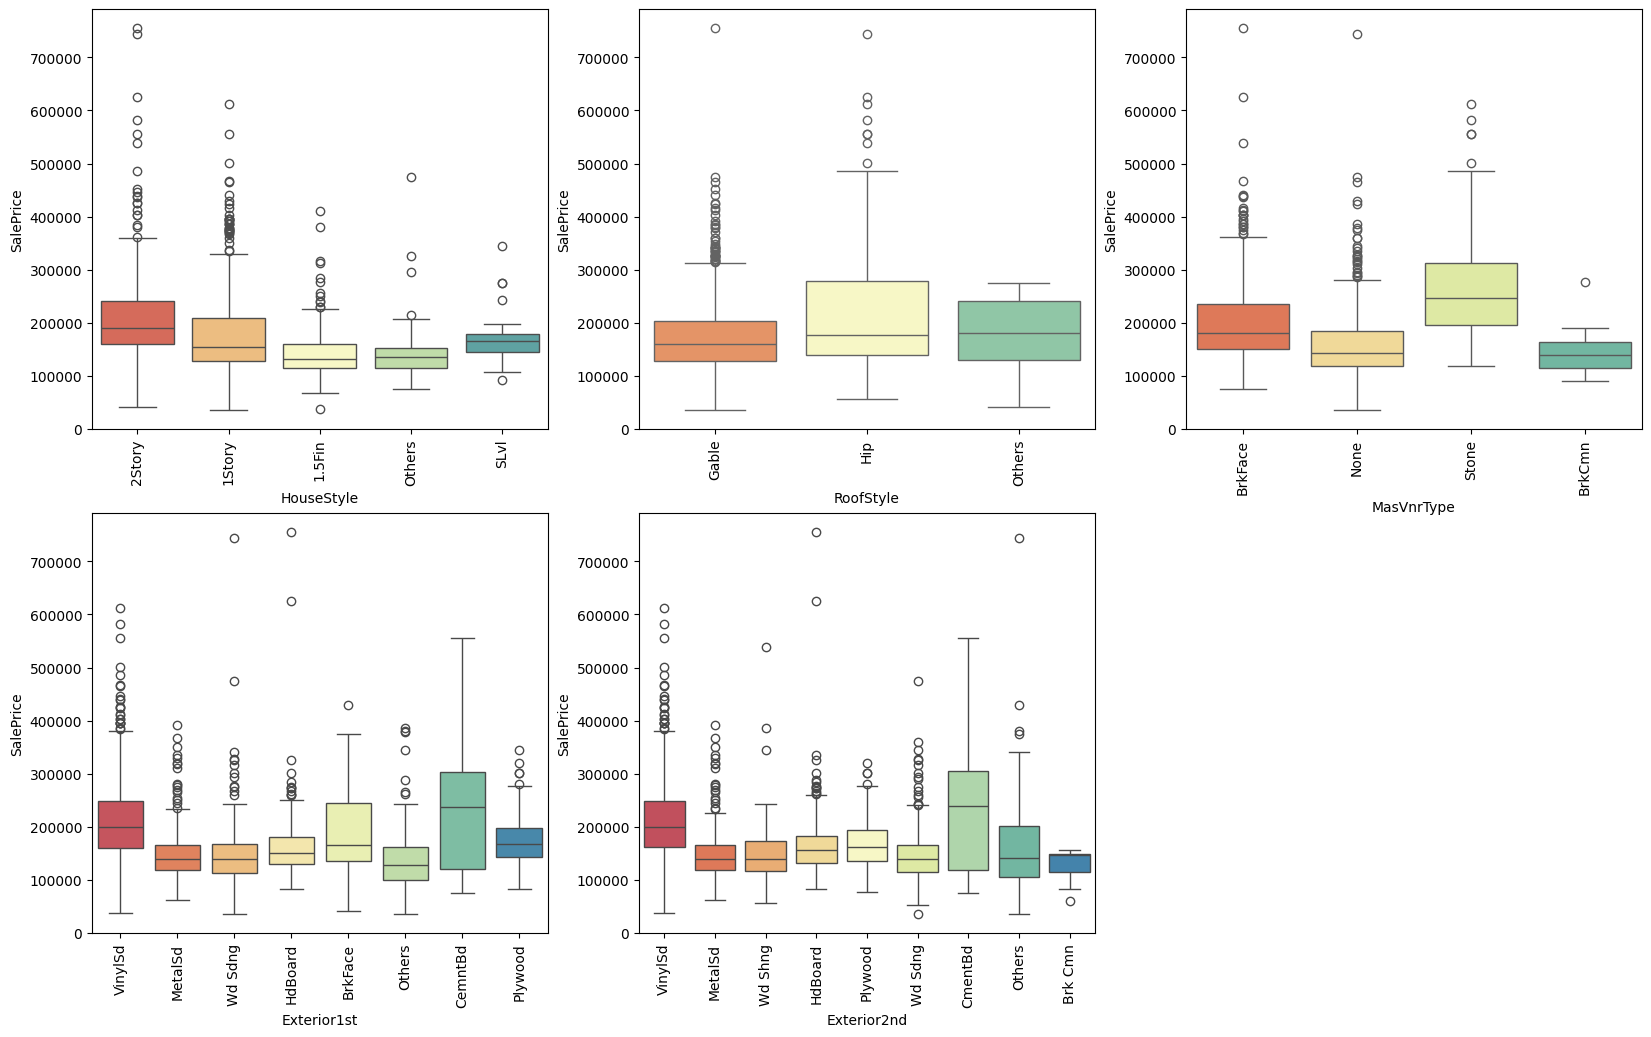

In [388]:
vars_cat = ['HouseStyle','RoofStyle', 'MasVnrType', 'Exterior1st', 'Exterior2nd']
display_boxplot(housing_df, vars_cat, 20, 12, 2, 3,'SalePrice', True)

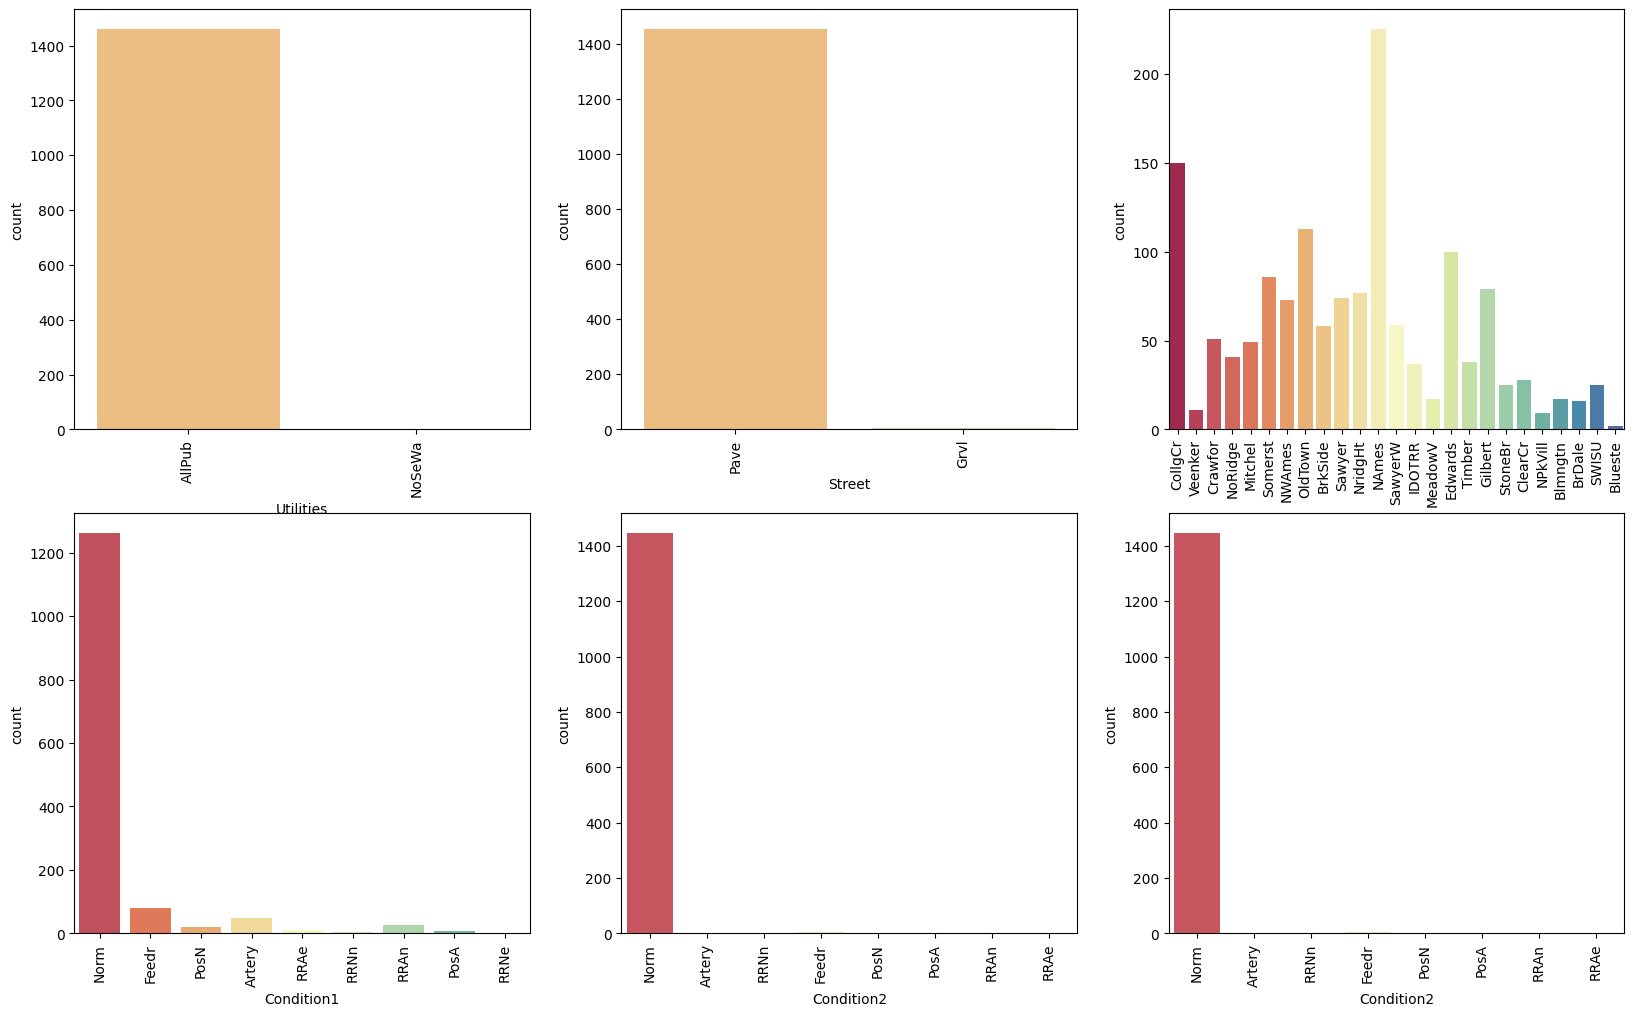

In [389]:
vars_cat = ['Utilities','Street','Neighborhood','Condition1','Condition2','Condition2']
display_countplot(housing_df, vars_cat, 20, 12, 2, 3, True)

In [390]:
# Dropping highly skewed column
housing_df.drop(['Utilities','Street','Condition1','Condition2'],axis=1,inplace=True)

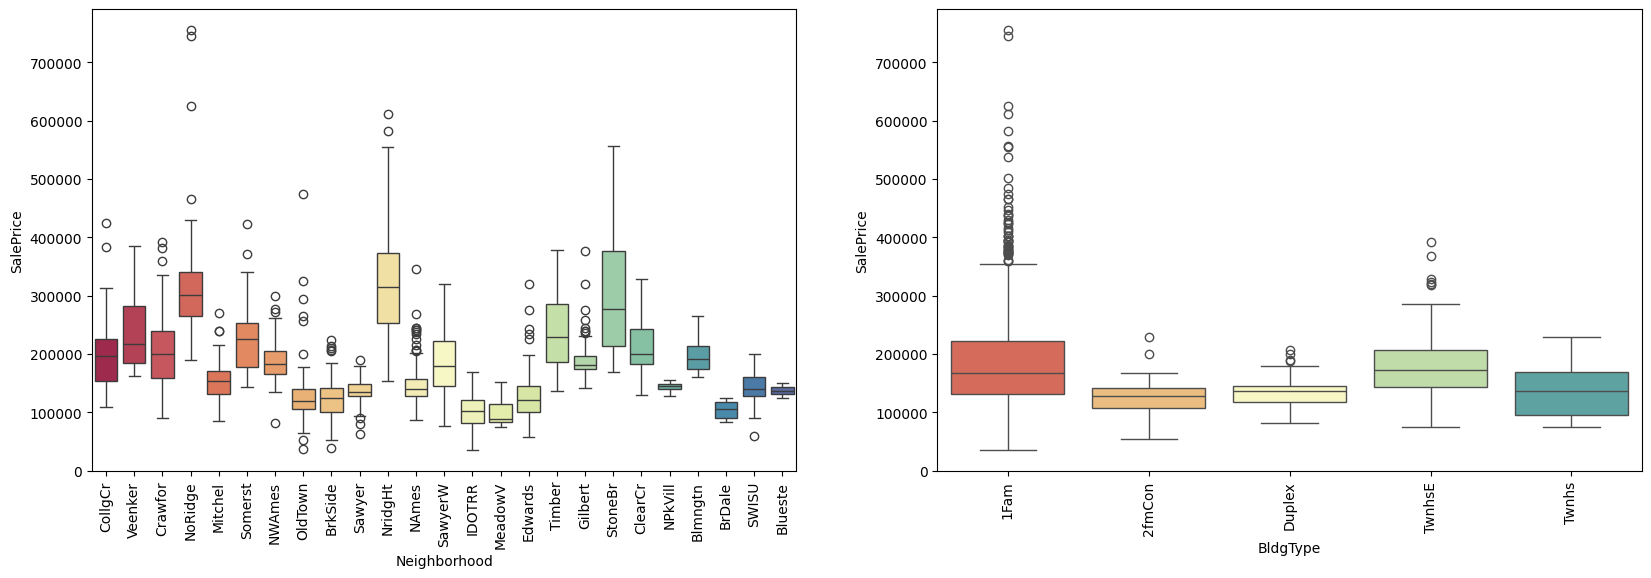

In [391]:
vars_cat = ['Neighborhood','BldgType']
display_boxplot(housing_df, vars_cat, 20, 6, 1, 2,'SalePrice', True)

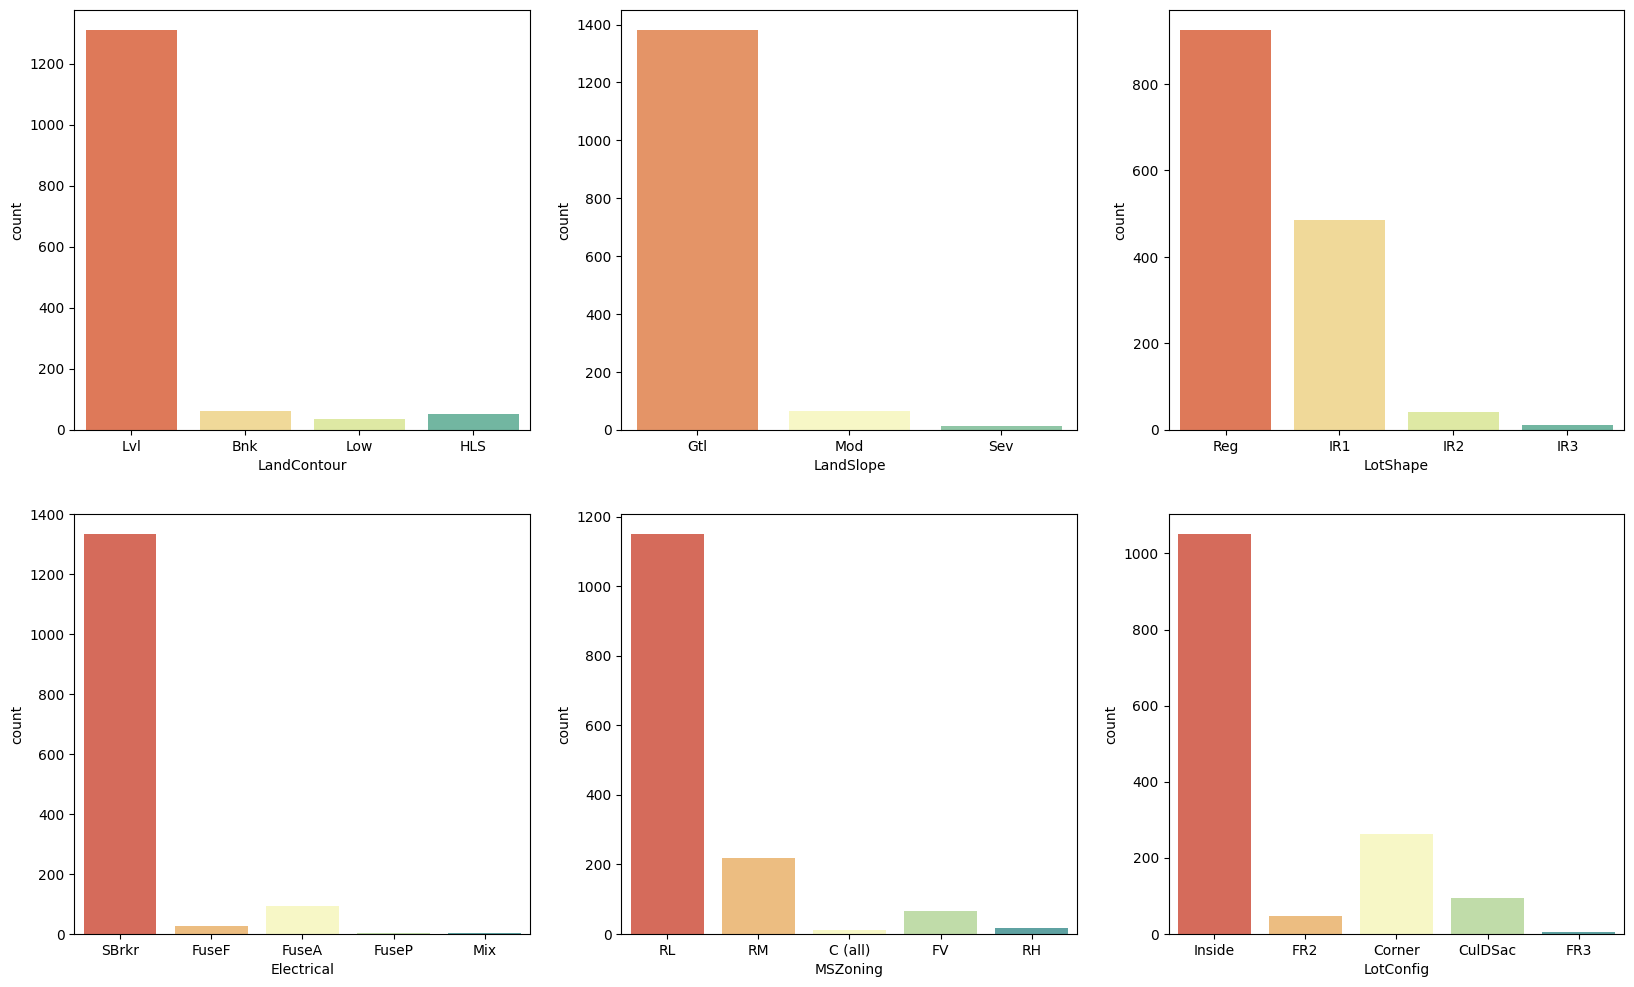

In [392]:
vars_cat = ['LandContour','LandSlope','LotShape','Electrical','MSZoning','LotConfig']
display_countplot(housing_df, vars_cat, 20, 12, 2, 3)

In [393]:
housing_df.drop(['LandSlope','LandContour','Electrical'],axis=1,inplace=True)

In [394]:
housing_df['MSZoning'] = housing_df['MSZoning'].replace(['RH','C (all)'],'Others')

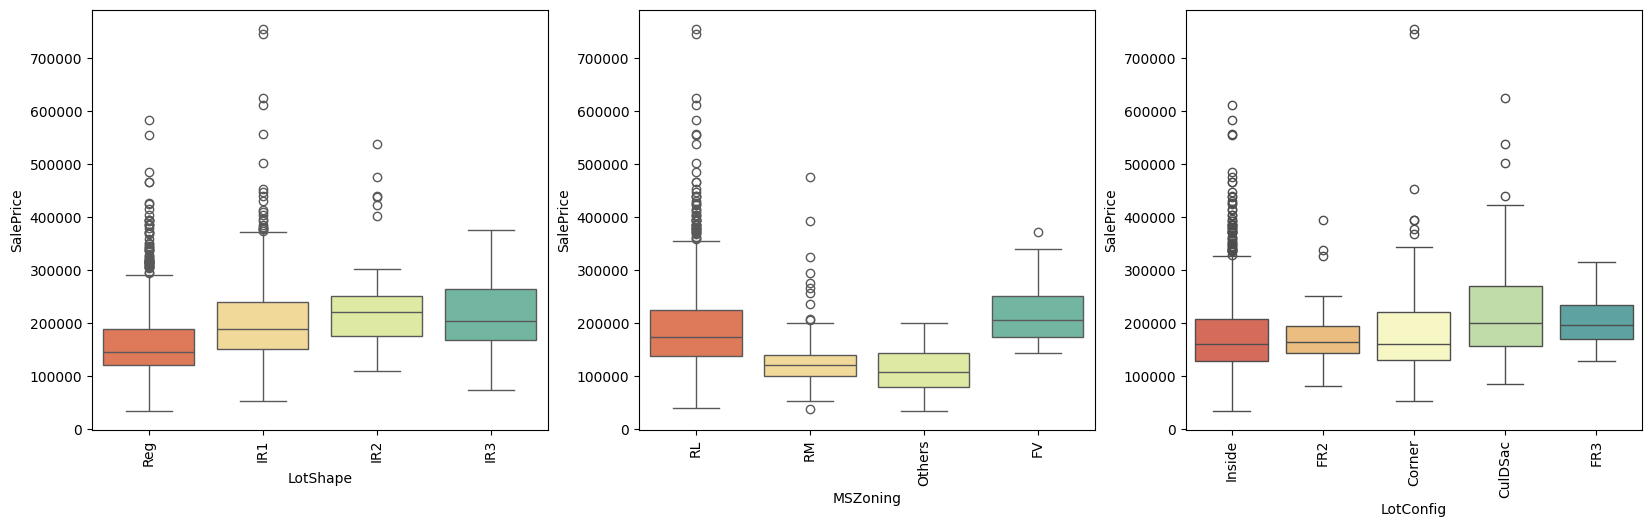

In [395]:
vars_cat = ['LotShape','MSZoning', 'LotConfig']
display_boxplot(housing_df, vars_cat, 20, 12, 2, 3,'SalePrice', True)

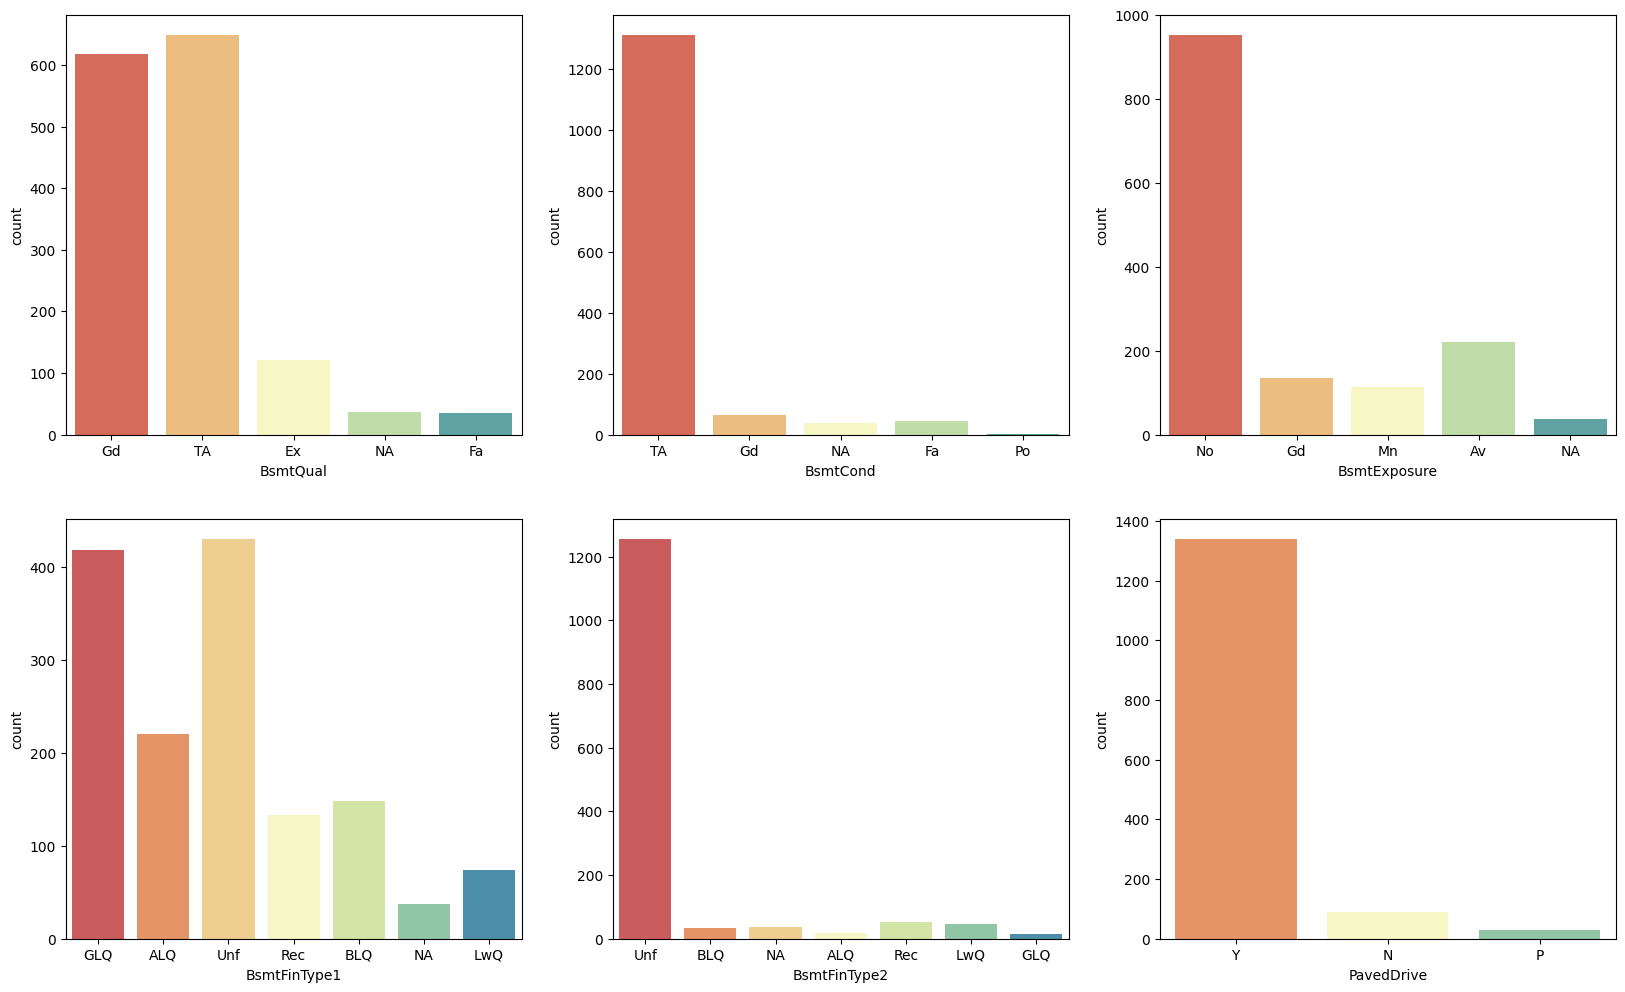

In [396]:
vars_cat = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','PavedDrive']
display_countplot(housing_df, vars_cat, 20, 12, 2, 3)

In [397]:
housing_df.drop(['BsmtFinType2','PavedDrive','BsmtCond'],axis=1,inplace=True)

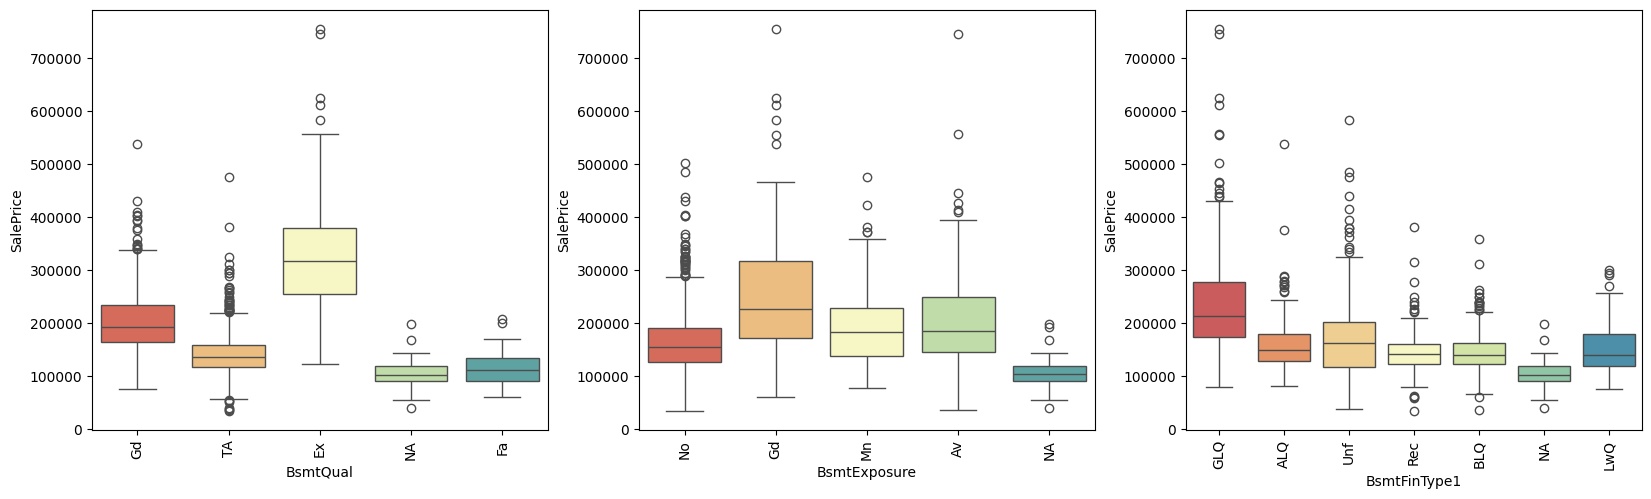

In [398]:
vars_cat = ['BsmtQual','BsmtExposure','BsmtFinType1']
display_boxplot(housing_df, vars_cat, 20, 12, 2, 3,'SalePrice', True)

In [399]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 63 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   BldgType       1460 non-null   object 
 10  HouseStyle     1460 non-null   object 
 11  OverallQual    1460 non-null   object 
 12  OverallCond    1460 non-null   object 
 13  YearBuilt      1460 non-null   int64  
 14  YearRemodAdd   1460 non-null   int64  
 15  RoofStyle      1460 non-null   object 
 16  Exterior1st    1460 non-null   object 
 17  Exterior2nd    1460 non-null   object 
 18  MasVnrTy

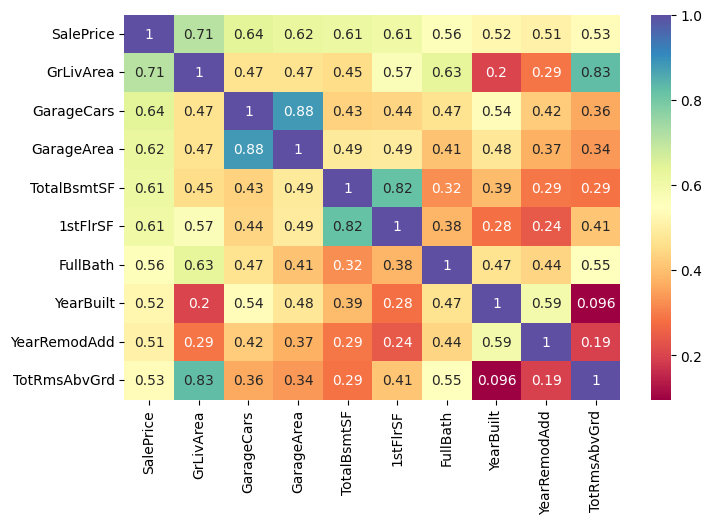

In [400]:
plt.figure(figsize=(8,5))

cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd']
# Heatmap
sns.heatmap(housing_df[cols].corr(), cmap="Spectral", annot=True)
plt.show()

In [401]:
housing_df['YearSinceRemodel'] = 2010 - ((housing_df['YearRemodAdd'] - housing_df['YearBuilt']) + housing_df['YearBuilt'])

In [402]:
housing_df.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)

In [403]:
#checking all categorical columns to form dummy variables
obj_df = housing_df.select_dtypes(include=['object'])
obj_df.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual',
       'GarageType', 'GarageFinish', 'SaleCondition'],
      dtype='object')

In [404]:
#checking all categorical columns to form dummy variables
num_df = housing_df.select_dtypes(include=['int64','float64'])
num_df.columns

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice',
       'YearSinceRemodel'],
      dtype='object')

In [405]:
# Dummy variables
obj_df = pd.get_dummies(obj_df, drop_first = True)
print(obj_df.shape)

(1460, 130)


In [406]:
obj_df.head()

,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_NA,GarageType_Others,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False


In [407]:
#housing_df.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)

In [408]:
# concat dummy variables with main dataset
housing_df = pd.concat([housing_df, obj_df], axis=1)

In [409]:
housing_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_NA,GarageType_Others,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,1,2-STORY 1946 & NEWER,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,...,False,False,False,False,False,True,False,True,False,False
1,2,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,...,False,False,False,False,False,True,False,True,False,False
2,3,2-STORY 1946 & NEWER,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,...,False,False,False,False,False,True,False,True,False,False
3,4,2-STORY 1945 & OLDER,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,...,False,True,False,False,False,False,True,False,False,False
4,5,2-STORY 1946 & NEWER,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,...,False,False,False,False,False,True,False,True,False,False


In [410]:
#removing columns as dummy variables already formed
housing_df.drop(['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish',
       'SaleCondition','Id','OverallCond','MSSubClass','OverallQual'],axis=1,inplace=True)

In [411]:
housing_df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_NA,GarageType_Others,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,False,False,False,False,False,True,False,True,False,False
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,False,False,False,False,False,True,False,True,False,False
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,False,False,False,False,False,True,False,True,False,False
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,False,True,False,False,False,False,True,False,False,False
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,False,False,False,False,False,True,False,True,False,False


In [412]:
#no need of these while making a model
housing_df.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis=1,inplace=True)

In [413]:
housing_df.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_NA,GarageType_Others,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,False,False,False,False,False,True,False,True,False,False
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,...,False,False,False,False,False,True,False,True,False,False
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,False,False,False,False,False,True,False,True,False,False
3,60.0,9550,0.0,216,0,540,756,961,756,0,...,False,True,False,False,False,False,True,False,False,False
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,False,False,False,False,False,True,False,True,False,False


In [414]:
#housing_df.drop(['Alley'],axis=1,inplace=True)
#housing_df.drop(['Fence'],axis=1,inplace=True)

In [415]:
# Putting feature variable to X
X = housing_df.drop(['SalePrice'], axis=1)

X.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_NA,GarageType_Others,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,False,False,False,False,False,True,False,True,False,False
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,...,False,False,False,False,False,True,False,True,False,False
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,False,False,False,False,False,True,False,True,False,False
3,60.0,9550,0.0,216,0,540,756,961,756,0,...,False,True,False,False,False,False,True,False,False,False
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,False,False,False,False,False,True,False,True,False,False


In [416]:
# Putting response variable to y
y = housing_df['SalePrice']

y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [417]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=100)

In [418]:
scaler = StandardScaler()

X_train[['LotFrontage', 'LotArea','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces','GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal']] = scaler.fit_transform(X_train[['LotFrontage', 'LotArea','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces','GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal']])

X_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageType_BuiltIn,GarageType_Detchd,GarageType_NA,GarageType_Others,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
210,-0.136829,-0.473765,-0.558025,0.043512,-0.293313,-0.374367,-0.430911,-0.765065,-0.787597,-0.124502,...,False,False,True,False,True,False,False,True,False,False
318,0.889247,-0.056845,0.809137,1.160345,-0.293313,-0.454644,0.621579,0.511914,2.140556,-0.124502,...,False,False,False,False,False,True,False,True,False,False
239,-0.806009,-0.169324,-0.558025,-0.761296,-0.293313,0.171964,-0.712011,-0.930972,0.795996,-0.124502,...,False,True,False,False,False,False,True,True,False,False
986,-0.493725,-0.502297,-0.558025,-0.963574,-0.293313,-0.175904,-1.256778,-0.420683,0.669584,-0.124502,...,False,False,False,False,False,False,True,True,False,False
1416,-0.449113,0.082905,-0.558025,-0.963574,-0.293313,0.475233,-0.620490,0.195183,1.611926,-0.124502,...,False,True,False,False,False,False,True,True,False,False


In [419]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

##Step 5: Model Building and Evaluation

###Ridge

In [420]:
# list of alphas to tune
params = {'alpha': [0.00004,0.0001, 0.001, 0.01, 0.1, 10,100,1000]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge,
                        param_grid = params,
                        scoring= 'r2',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [4e-05, 0.0001, 0.001, 0.01, 0.1, 10, 100,
                                   1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [421]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=100]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.024947,0.003145,0.011296,0.000959,0.00004,{'alpha': 4e-05},0.834264,0.715944,0.754170,0.878284,...,0.804621,0.059995,6,0.895593,0.914623,0.910536,0.889112,0.895626,0.901098,0.009756
1,0.019728,0.007018,0.008622,0.002674,0.0001,{'alpha': 0.0001},0.834265,0.715943,0.754171,0.878285,...,0.804622,0.059996,5,0.895593,0.914623,0.910536,0.889112,0.895626,0.901098,0.009756
2,0.014243,0.004022,0.007501,0.002921,0.001,{'alpha': 0.001},0.834282,0.715936,0.754188,0.878301,...,0.804640,0.060006,4,0.895593,0.914623,0.910536,0.889112,0.895626,0.901098,0.009756
3,0.031236,0.012193,0.014353,0.004332,0.01,{'alpha': 0.01},0.834448,0.715866,0.754365,0.878456,...,0.804813,0.060104,3,0.895593,0.914623,0.910535,0.889111,0.895624,0.901097,0.009756
4,0.018458,0.005660,0.006881,0.002201,0.1,{'alpha': 0.1},0.835939,0.715108,0.756061,0.879775,...,0.806196,0.060902,2,0.895561,0.914583,0.910494,0.889073,0.895500,0.901042,0.009764


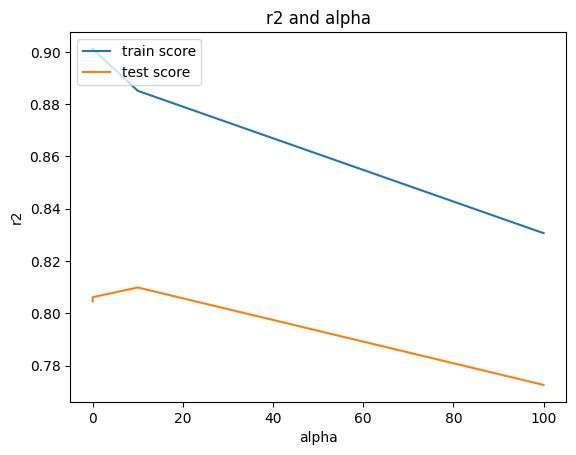

In [422]:
# plotting mean test and train scoes with alpha
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [423]:
#optimum alpha
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-1.71063424e+02,  4.11030058e-01,  1.83028649e+01,  4.04360711e-01,
        1.76932225e+00,  4.52580587e+00,  6.69948855e+00,  1.80147987e+01,
        4.15865043e+01, -3.55701125e+01,  2.40311864e+01,  7.51967432e+03,
        3.24808283e+03,  8.95086491e+03,  3.51843223e+03, -1.90973228e+03,
       -1.71620423e+04,  3.97074491e+02,  5.53607367e+03,  1.39663470e+04,
       -7.43292155e+00,  1.12980809e+01, -1.64296406e+01,  1.23471627e+01,
        4.82003905e+01,  3.22349273e+01, -1.78828705e+01, -2.56462777e-01,
       -9.09300117e+01, -1.65388516e+02,  3.89738664e+02, -3.94648150e+03,
        9.67031381e+03, -6.44493797e+03,  2.23699848e+03, -4.42629926e+03,
       -3.45693914e+03, -1.05307852e+03,  2.22871608e+03, -6.23632232e+03,
       -4.15591513e+02, -2.99729454e+03,  2.82954691e+03,  3.08606163e+03,
       -7.11597488e+03,  1.44548725e+03, -4.11352206e+03,  1.82556074e+03,
       -1.30374950e+04,  1.39298061e+03,  7.31736911e+03, -8.97790786e+03,
       -2.95347971e+03, -

In [424]:
ridge.score(X_train,y_train)

0.8806092263496584

In [425]:
ridge.score(X_test,y_test)

0.864253326010091

In [426]:
# Ridge model parameters
model_parameters = list(sorted(ridge.coef_))
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 126003.163),
 ('LotFrontage', -22572.219),
 ('LotArea', -21873.866),
 ('MasVnrArea', -18510.592),
 ('BsmtFinSF1', -18482.842),
 ('BsmtFinSF2', -17920.491),
 ('BsmtUnfSF', -17162.042),
 ('TotalBsmtSF', -15215.521),
 ('1stFlrSF', -14037.565),
 ('2ndFlrSF', -13737.481),
 ('LowQualFinSF', -13410.574),
 ('GrLivArea', -13037.495),
 ('BsmtFullBath', -10636.929),
 ('BsmtHalfBath', -10610.854),
 ('FullBath', -9627.135),
 ('HalfBath', -9531.5),
 ('BedroomAbvGr', -9392.819),
 ('KitchenAbvGr', -9303.87),
 ('TotRmsAbvGrd', -9280.08),
 ('Fireplaces', -9064.068),
 ('GarageCars', -9045.604),
 ('GarageArea', -9042.611),
 ('WoodDeckSF', -9042.611),
 ('OpenPorchSF', -8977.908),
 ('EnclosedPorch', -8564.252),
 ('3SsnPorch', -8415.824),
 ('ScreenPorch', -7778.023),
 ('PoolArea', -7339.325),
 ('MiscVal', -7115.975),
 ('MoSold', -7105.444),
 ('YearSinceRemodel', -6993.418),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -6496.365),
 ('MSSubClass_1-STORY 1945 & OLDER', -6444.938),
 ('MSSubClass_1

###Lasso

In [427]:
params = {'alpha': [0.00006,0.0006, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008 ]}
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso,
                        param_grid = params,
                        scoring= 'r2',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.767e+11, tolerance: 5.301e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e+11, tolerance: 4.851e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.308e+11, tolerance: 5.169e

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [6e-05, 0.0006, 0.0008, 0.001, 0.002, 0.004,
                                   0.006, 0.008]},
             return_train_score=True, scoring='r2', verbose=1)

In [428]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.195796,0.015259,0.008870,0.002479,0.00006,{'alpha': 6e-05},0.834264,0.715951,0.754169,0.878336,...,0.804632,0.060006,8,0.895593,0.914623,0.910536,0.889111,0.895626,0.901098,0.009756
1,0.221361,0.030038,0.007574,0.002114,0.0006,{'alpha': 0.0006},0.834264,0.715951,0.754169,0.878336,...,0.804633,0.060006,7,0.895593,0.914623,0.910536,0.889111,0.895626,0.901098,0.009756
2,0.225725,0.018428,0.008461,0.002096,0.0008,{'alpha': 0.0008},0.834264,0.715951,0.754169,0.878336,...,0.804633,0.060006,6,0.895593,0.914623,0.910536,0.889111,0.895626,0.901098,0.009756
3,0.274647,0.059004,0.009421,0.001758,0.001,{'alpha': 0.001},0.834265,0.715951,0.754169,0.878336,...,0.804633,0.060006,5,0.895593,0.914623,0.910536,0.889111,0.895626,0.901098,0.009756
4,0.400234,0.010910,0.015879,0.004588,0.002,{'alpha': 0.002},0.834265,0.715951,0.754170,0.878337,...,0.804633,0.060006,4,0.895593,0.914623,0.910536,0.889111,0.895626,0.901098,0.009756


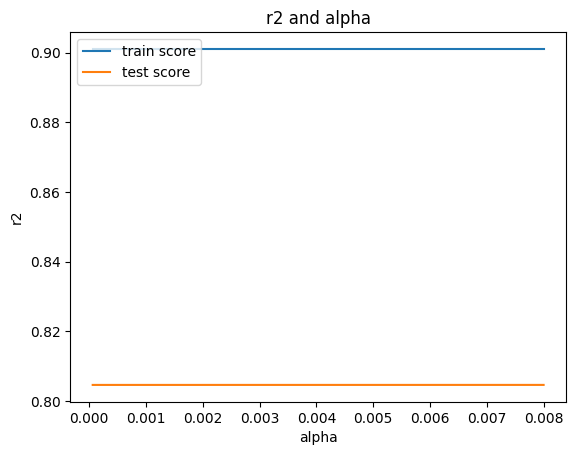

In [429]:
# plotting mean test and train scoes with alpha
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')

plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [430]:
#optimum alpha
alpha =0.001

lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.376e+11, tolerance: 6.381e+08
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001)

In [431]:
lasso.coef_

array([-2.05751257e+02,  4.37080777e-01,  4.61554894e+00, -4.50575230e+00,
       -2.22769429e-01,  2.90092196e+00,  1.55641965e+00,  2.97196608e+01,
        5.65408890e+01, -8.17977550e+00,  6.77730544e+00,  8.46672990e+03,
        5.18626624e+03,  1.01133404e+04,  4.19130186e+03, -9.62558600e+02,
       -2.05840218e+04,  6.86116182e+02,  3.87151733e+03,  1.31255007e+04,
       -1.23014429e+01,  8.55675824e+00, -1.85486939e+01,  2.26932204e+01,
        5.97522576e+01,  3.73489129e+01, -7.78964189e+00,  2.15709249e-01,
       -1.60003021e+02, -8.12379706e+01, -2.64489589e+03, -1.40281543e+04,
       -3.59142877e+03, -1.32204034e+04, -4.21252878e+03, -2.35689054e+04,
       -1.93567102e+04, -1.46864495e+04, -1.02232430e+04, -1.03144626e+04,
       -1.66766743e+04, -9.86083983e+03, -3.48247588e+03, -4.29248776e+03,
       -2.48106555e+03,  4.98637073e+03,  6.87342009e+03,  4.11359992e+03,
       -1.74685214e+04,  1.74337733e+03,  4.56293659e+03, -1.66664087e+04,
       -1.72685926e+04, -

In [432]:
lasso.score(X_train,y_train)

0.8930868741006273

In [433]:
lasso.score(X_test,y_test)

0.8592212691062189

In [434]:
# lasso model parameters
model_parameters = list(sorted(lasso.coef_))
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list((zip(cols, model_parameters)))

[('constant', 131670.165),
 ('LotFrontage', -42834.968),
 ('LotArea', -39592.582),
 ('MasVnrArea', -39580.167),
 ('BsmtFinSF1', -39442.732),
 ('BsmtFinSF2', -30442.603),
 ('BsmtUnfSF', -30222.228),
 ('TotalBsmtSF', -29488.208),
 ('1stFlrSF', -28930.045),
 ('2ndFlrSF', -25147.27),
 ('LowQualFinSF', -24622.296),
 ('GrLivArea', -23568.905),
 ('BsmtFullBath', -23002.235),
 ('BsmtHalfBath', -22394.084),
 ('FullBath', -22053.104),
 ('HalfBath', -21771.852),
 ('BedroomAbvGr', -21548.248),
 ('KitchenAbvGr', -20584.022),
 ('TotRmsAbvGrd', -20523.681),
 ('Fireplaces', -19842.04),
 ('GarageCars', -19356.71),
 ('GarageArea', -17927.224),
 ('WoodDeckSF', -17468.521),
 ('OpenPorchSF', -17268.593),
 ('EnclosedPorch', -16676.674),
 ('3SsnPorch', -16666.409),
 ('ScreenPorch', -16386.697),
 ('PoolArea', -14977.681),
 ('MiscVal', -14974.364),
 ('MoSold', -14686.449),
 ('YearSinceRemodel', -14028.154),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -13220.403),
 ('MSSubClass_1-STORY 1945 & OLDER', -12926.0

##Step 6: Conclusion

*   Ridge : Train :88.0 Test :86.4
*   Lasso : Train :89.3 Test :85.9




**Top 5 most significant variables in Ridge are:**

*   ('SaleCondition_Partial', 36708.443)
*   ('SaleCondition_Others', 34336.679)
*   ('SaleCondition_Normal', 32833.096)
*   ('GarageFinish_Unf', 26005.843)
*   ('GarageFinish_RFn', 20233.527)


**Top 5 most significant variables in Lasso are**

*   ('SaleCondition_Partial', 97338.089)
*   ('SaleCondition_Others', 69914.191)
*   ('SaleCondition_Normal', 63790.694)
*   ('GarageFinish_Unf', 46748.918)
*   ('GarageFinish_RFn', 37314.822)


